In [99]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import yfinance as yf
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from time import time
from arch import arch_model

from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

#in practice do not supress these warnings, they carry important information about the status of your model
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

**PART1**

In [100]:
bitcoin = 'BTC-USD'
start_date = datetime(2021,7,1)
train_end_date = datetime(2023,7,1)
end_date = datetime(2023,12,1)

In [101]:
bitcoin_tickerDf = yf.Ticker(bitcoin)
bitcoin_tickerDf = bitcoin_tickerDf.history(period='1d', start=start_date, end=end_date)
bitcoin_close = bitcoin_tickerDf['Close']

In [102]:
train_bitcoin = bitcoin_close[start_date:end_date]

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5928\985079761.py:1: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  train_bitcoin = bitcoin_close[start_date:end_date]


**PART2**

In [103]:
p_len = 6
q_len = 6
d = 0
def best_arima_combo(train_data):
    # combo = list(itertools.product(p_range, [0], q_range))  # Assuming d=0 for no differencing
    best_aic = float("inf")
    best_order = None
    best_model = None
    for p in range(p_len):
        for q in range(q_len):
            try:
                model = ARIMA(train_data, order=(p, d, q))
                model_fit = model.fit()
                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_model = model_fit
                    best_order = (p, d, q)
            except:
                continue

    return best_order,best_model



In [104]:
window_size =  (train_end_date  - start_date).days
means = []
residuals = []
res = []

**Train Model**

In [105]:
# https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html

def train_models(train_data):
    for i in range(len(train_data) - window_size):
        window_data = train_data.iloc[i:i + window_size + 1]

        # best arima order and model
        best_order,best_arima_model = best_arima_combo(window_data)
        # best_arima_model = ARIMA(window_data, order=best_order).fit()
        residual = best_arima_model.resid
        residuals.append(residual)
        
        # train garch
        garch_model= arch_model(residual, vol='Garch', p=best_order[0], q=best_order[2])
        garch_fit = garch_model.fit()
        garch_forecast = garch_fit.forecast(horizon=1)
        garch_mean = garch_forecast.mean
        means.append(garch_mean.iloc[-1])
    
    data = [m[0] for m in means]
    return pd.DataFrame(data, columns=['Mean'], index=train_data.loc[train_end_date:end_date].index)

    

In [107]:
#BTC
train_results = train_models(train_bitcoin)

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-

Iteration:      1,   Func. Count:     13,   Neg. LLF: 7927.513172604383
Iteration:      2,   Func. Count:     26,   Neg. LLF: 6083.016554720771
Iteration:      3,   Func. Count:     39,   Neg. LLF: 6080.797556934123
Iteration:      4,   Func. Count:     52,   Neg. LLF: 6061.071764921937
Iteration:      5,   Func. Count:     65,   Neg. LLF: 6054.056234878923
Iteration:      6,   Func. Count:     78,   Neg. LLF: 6063.646094506386
Iteration:      7,   Func. Count:     91,   Neg. LLF: 6045.755472800585
Iteration:      8,   Func. Count:    103,   Neg. LLF: 6045.169255576304
Iteration:      9,   Func. Count:    115,   Neg. LLF: 6429.654581018102
Iteration:     10,   Func. Count:    128,   Neg. LLF: 6050.665445890416
Iteration:     11,   Func. Count:    141,   Neg. LLF: 6044.873232371113
Iteration:     12,   Func. Count:    153,   Neg. LLF: 6044.864881934827
Iteration:     13,   Func. Count:    165,   Neg. LLF: 6044.860254079202
Iteration:     14,   Func. Count:    177,   Neg. LLF: 6044.85860

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 7902.225003494759
Iteration:      2,   Func. Count:     26,   Neg. LLF: 6082.92282846574
Iteration:      3,   Func. Count:     39,   Neg. LLF: 6076.142519322497
Iteration:      4,   Func. Count:     52,   Neg. LLF: 6055.495813150065
Iteration:      5,   Func. Count:     65,   Neg. LLF: 6062.7141225718515
Iteration:      6,   Func. Count:     78,   Neg. LLF: 6064.934844927256
Iteration:      7,   Func. Count:     91,   Neg. LLF: 6046.84385946578
Iteration:      8,   Func. Count:    104,   Neg. LLF: 6045.334583987572
Iteration:      9,   Func. Count:    116,   Neg. LLF: 6047.362019410469
Iteration:     10,   Func. Count:    129,   Neg. LLF: 6285.0009808329705
Iteration:     11,   Func. Count:    143,   Neg. LLF: 6044.96426923129
Iteration:     12,   Func. Count:    156,   Neg. LLF: 6044.6408773654475
Iteration:     13,   Func. Count:    168,   Neg. LLF: 6044.639361553642
Iteration:     14,   Func. Count:    180,   Neg. LLF: 6044.63654

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 7921.316957843792
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6089.90694521327
Iteration:      3,   Func. Count:     28,   Neg. LLF: 6066.529766770482
Iteration:      4,   Func. Count:     37,   Neg. LLF: 6085.956539076033
Iteration:      5,   Func. Count:     46,   Neg. LLF: 6064.988057563853
Iteration:      6,   Func. Count:     54,   Neg. LLF: 6061.792929679004
Iteration:      7,   Func. Count:     62,   Neg. LLF: 6071.56985802527
Iteration:      8,   Func. Count:     71,   Neg. LLF: 6061.518857146661
Iteration:      9,   Func. Count:     79,   Neg. LLF: 6061.512125307913
Iteration:     10,   Func. Count:     87,   Neg. LLF: 6061.508011619725
Iteration:     11,   Func. Count:     95,   Neg. LLF: 6061.503059505197
Iteration:     12,   Func. Count:    103,   Neg. LLF: 6061.498267041304
Iteration:     13,   Func. Count:    111,   Neg. LLF: 6061.496625668886
Iteration:     14,   Func. Count:    119,   Neg. LLF: 6061.4962668

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 7925.140482276521
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6089.651438277686
Iteration:      3,   Func. Count:     28,   Neg. LLF: 6116.887951783596
Iteration:      4,   Func. Count:     37,   Neg. LLF: 6087.464349244838
Iteration:      5,   Func. Count:     46,   Neg. LLF: 6064.85588880771
Iteration:      6,   Func. Count:     54,   Neg. LLF: 6064.6601690167845
Iteration:      7,   Func. Count:     62,   Neg. LLF: 6104.277543051064
Iteration:      8,   Func. Count:     71,   Neg. LLF: 6062.833456615789
Iteration:      9,   Func. Count:     79,   Neg. LLF: 6062.689167141472
Iteration:     10,   Func. Count:     87,   Neg. LLF: 6062.646714088047
Iteration:     11,   Func. Count:     95,   Neg. LLF: 6062.646425769044
Iteration:     12,   Func. Count:    104,   Neg. LLF: 6062.637655066848
Iteration:     13,   Func. Count:    112,   Neg. LLF: 6072.27742474379
Iteration:     14,   Func. Count:    123,   Neg. LLF: 6063.607923

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 7910.553683350319
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6086.357899418737
Iteration:      3,   Func. Count:     28,   Neg. LLF: 6063.601020216964
Iteration:      4,   Func. Count:     37,   Neg. LLF: 6083.0822810278705
Iteration:      5,   Func. Count:     46,   Neg. LLF: 6061.8319019412775
Iteration:      6,   Func. Count:     54,   Neg. LLF: 6059.4551552114
Iteration:      7,   Func. Count:     62,   Neg. LLF: 6074.466110407528
Iteration:      8,   Func. Count:     71,   Neg. LLF: 6059.012941901272
Iteration:      9,   Func. Count:     79,   Neg. LLF: 6059.006077503006
Iteration:     10,   Func. Count:     87,   Neg. LLF: 6058.995884060301
Iteration:     11,   Func. Count:     95,   Neg. LLF: 6058.990283789665
Iteration:     12,   Func. Count:    103,   Neg. LLF: 6058.983563911836
Iteration:     13,   Func. Count:    111,   Neg. LLF: 6058.982281544015
Iteration:     14,   Func. Count:    119,   Neg. LLF: 6058.98183

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 7882.871503610896
Iteration:      2,   Func. Count:     26,   Neg. LLF: 6079.14172562422
Iteration:      3,   Func. Count:     39,   Neg. LLF: 6070.838940099882
Iteration:      4,   Func. Count:     52,   Neg. LLF: 6065.789628800964
Iteration:      5,   Func. Count:     65,   Neg. LLF: 6052.99154372431
Iteration:      6,   Func. Count:     78,   Neg. LLF: 6065.2352339098425
Iteration:      7,   Func. Count:     91,   Neg. LLF: 6044.089077707221
Iteration:      8,   Func. Count:    104,   Neg. LLF: 6042.8908058887
Iteration:      9,   Func. Count:    116,   Neg. LLF: 6047.671761568114
Iteration:     10,   Func. Count:    129,   Neg. LLF: 6134.394894561278
Iteration:     11,   Func. Count:    142,   Neg. LLF: 6042.543356486203
Iteration:     12,   Func. Count:    155,   Neg. LLF: 6041.895262271633
Iteration:     13,   Func. Count:    168,   Neg. LLF: 6041.855180325161
Iteration:     14,   Func. Count:    180,   Neg. LLF: 6041.85263932

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 7890.808176033002
Iteration:      2,   Func. Count:     26,   Neg. LLF: 6078.5959485759195
Iteration:      3,   Func. Count:     39,   Neg. LLF: 6069.383409079066
Iteration:      4,   Func. Count:     52,   Neg. LLF: 6061.296028776671
Iteration:      5,   Func. Count:     65,   Neg. LLF: 6053.457056661951
Iteration:      6,   Func. Count:     78,   Neg. LLF: 6064.652292662282
Iteration:      7,   Func. Count:     91,   Neg. LLF: 6043.068444190939
Iteration:      8,   Func. Count:    103,   Neg. LLF: 6041.931509387099
Iteration:      9,   Func. Count:    115,   Neg. LLF: 6201.952174389058
Iteration:     10,   Func. Count:    129,   Neg. LLF: 6041.423178864243
Iteration:     11,   Func. Count:    142,   Neg. LLF: 6041.941992267816
Iteration:     12,   Func. Count:    155,   Neg. LLF: 6041.19590089781
Iteration:     13,   Func. Count:    168,   Neg. LLF: 6041.088776916717
Iteration:     14,   Func. Count:    180,   Neg. LLF: 6041.08488

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 7885.59290596631
Iteration:      2,   Func. Count:     26,   Neg. LLF: 6077.2683249101
Iteration:      3,   Func. Count:     39,   Neg. LLF: 6066.1892673834445
Iteration:      4,   Func. Count:     52,   Neg. LLF: 6100.620182919661
Iteration:      5,   Func. Count:     65,   Neg. LLF: 6048.658492461243
Iteration:      6,   Func. Count:     78,   Neg. LLF: 6061.9113344053185
Iteration:      7,   Func. Count:     91,   Neg. LLF: 6042.188205323326
Iteration:      8,   Func. Count:    104,   Neg. LLF: 6040.606322603312
Iteration:      9,   Func. Count:    116,   Neg. LLF: 6042.839729653342
Iteration:     10,   Func. Count:    129,   Neg. LLF: 6051.20081483843
Iteration:     11,   Func. Count:    142,   Neg. LLF: 6043.991821550638
Iteration:     12,   Func. Count:    155,   Neg. LLF: 6039.540149884448
Iteration:     13,   Func. Count:    168,   Neg. LLF: 6039.464608737482
Iteration:     14,   Func. Count:    180,   Neg. LLF: 6039.4611153

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 7861.226224230649
Iteration:      2,   Func. Count:     26,   Neg. LLF: 6076.452279444045
Iteration:      3,   Func. Count:     39,   Neg. LLF: 6066.05647596847
Iteration:      4,   Func. Count:     52,   Neg. LLF: 6066.30150291204
Iteration:      5,   Func. Count:     65,   Neg. LLF: 6049.461227601076
Iteration:      6,   Func. Count:     78,   Neg. LLF: 6064.457906431795
Iteration:      7,   Func. Count:     91,   Neg. LLF: 6042.073858495346
Iteration:      8,   Func. Count:    104,   Neg. LLF: 6040.2159844746275
Iteration:      9,   Func. Count:    116,   Neg. LLF: 6041.149106185652
Iteration:     10,   Func. Count:    129,   Neg. LLF: 6114.757425916278
Iteration:     11,   Func. Count:    142,   Neg. LLF: 6039.831184469414
Iteration:     12,   Func. Count:    155,   Neg. LLF: 6039.110628391756
Iteration:     13,   Func. Count:    167,   Neg. LLF: 6039.098392941159
Iteration:     14,   Func. Count:    179,   Neg. LLF: 6039.096410

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 7878.439334097257
Iteration:      2,   Func. Count:     26,   Neg. LLF: 6075.721263774712
Iteration:      3,   Func. Count:     39,   Neg. LLF: 6064.433227416518
Iteration:      4,   Func. Count:     52,   Neg. LLF: 6105.242371684851
Iteration:      5,   Func. Count:     65,   Neg. LLF: 6047.375819250656
Iteration:      6,   Func. Count:     78,   Neg. LLF: 6063.617577602938
Iteration:      7,   Func. Count:     91,   Neg. LLF: 6041.762399571034
Iteration:      8,   Func. Count:    104,   Neg. LLF: 6039.680541634797
Iteration:      9,   Func. Count:    116,   Neg. LLF: 6040.825270847445
Iteration:     10,   Func. Count:    129,   Neg. LLF: 6040.871887615111
Iteration:     11,   Func. Count:    142,   Neg. LLF: 6042.614337558674
Iteration:     12,   Func. Count:    155,   Neg. LLF: 6038.555920657438
Iteration:     13,   Func. Count:    168,   Neg. LLF: 6038.470110129583
Iteration:     14,   Func. Count:    180,   Neg. LLF: 6038.46666

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 7834.808496970953
Iteration:      2,   Func. Count:     26,   Neg. LLF: 6073.386949691041
Iteration:      3,   Func. Count:     39,   Neg. LLF: 6060.807924477602
Iteration:      4,   Func. Count:     52,   Neg. LLF: 6054.204470006133
Iteration:      5,   Func. Count:     65,   Neg. LLF: 6046.965300325193
Iteration:      6,   Func. Count:     78,   Neg. LLF: 6055.668968075317
Iteration:      7,   Func. Count:     91,   Neg. LLF: 6037.7946708298805
Iteration:      8,   Func. Count:    103,   Neg. LLF: 6037.8638448671745
Iteration:      9,   Func. Count:    116,   Neg. LLF: 6125.1754901568165
Iteration:     10,   Func. Count:    130,   Neg. LLF: 6037.065577282681
Iteration:     11,   Func. Count:    143,   Neg. LLF: 6037.088788023015
Iteration:     12,   Func. Count:    156,   Neg. LLF: 6037.041492626266
Iteration:     13,   Func. Count:    168,   Neg. LLF: 6037.0398009662895
Iteration:     14,   Func. Count:    180,   Neg. LLF: 6037.0

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 7968.821156331201
Iteration:      2,   Func. Count:     26,   Neg. LLF: 6072.485861735839
Iteration:      3,   Func. Count:     39,   Neg. LLF: 6082.713082335751
Iteration:      4,   Func. Count:     52,   Neg. LLF: 6432.936360826936
Iteration:      5,   Func. Count:     65,   Neg. LLF: 6076.883209083165
Iteration:      6,   Func. Count:     78,   Neg. LLF: 6073.510583588746
Iteration:      7,   Func. Count:     91,   Neg. LLF: 6069.296598150555
Iteration:      8,   Func. Count:    104,   Neg. LLF: 6076.597650005009
Iteration:      9,   Func. Count:    117,   Neg. LLF: 6044.782721675945
Iteration:     10,   Func. Count:    129,   Neg. LLF: 6048.934408876764
Iteration:     11,   Func. Count:    142,   Neg. LLF: 6050.897598537869
Iteration:     12,   Func. Count:    156,   Neg. LLF: 6042.703509085212
Iteration:     13,   Func. Count:    168,   Neg. LLF: 6043.101480087403
Iteration:     14,   Func. Count:    181,   Neg. LLF: 6042.36171

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 7991.488375550927
Iteration:      2,   Func. Count:     26,   Neg. LLF: 6073.130030084181
Iteration:      3,   Func. Count:     39,   Neg. LLF: 6087.29477824244
Iteration:      4,   Func. Count:     52,   Neg. LLF: 6674.648573300285
Iteration:      5,   Func. Count:     65,   Neg. LLF: 6079.725240539328
Iteration:      6,   Func. Count:     78,   Neg. LLF: 6079.245958818417
Iteration:      7,   Func. Count:     91,   Neg. LLF: 6068.562271277085
Iteration:      8,   Func. Count:    104,   Neg. LLF: 6072.73894811952
Iteration:      9,   Func. Count:    117,   Neg. LLF: 6048.380555944987
Iteration:     10,   Func. Count:    130,   Neg. LLF: 6044.348463391743
Iteration:     11,   Func. Count:    142,   Neg. LLF: 6048.335068631156
Iteration:     12,   Func. Count:    155,   Neg. LLF: 6046.804043608399
Iteration:     13,   Func. Count:    168,   Neg. LLF: 6043.701369171144
Iteration:     14,   Func. Count:    181,   Neg. LLF: 6043.2367347

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 8030.109025247908
Iteration:      2,   Func. Count:     26,   Neg. LLF: 6073.864748478495
Iteration:      3,   Func. Count:     39,   Neg. LLF: 6088.015115997323
Iteration:      4,   Func. Count:     52,   Neg. LLF: 6665.162024063735
Iteration:      5,   Func. Count:     65,   Neg. LLF: 6083.256419277239
Iteration:      6,   Func. Count:     78,   Neg. LLF: 6080.624878901854
Iteration:      7,   Func. Count:     91,   Neg. LLF: 6070.272893688326
Iteration:      8,   Func. Count:    104,   Neg. LLF: 6078.544155392823
Iteration:      9,   Func. Count:    117,   Neg. LLF: 6047.287800589565
Iteration:     10,   Func. Count:    129,   Neg. LLF: 6051.658602482238
Iteration:     11,   Func. Count:    142,   Neg. LLF: 6050.550642628781
Iteration:     12,   Func. Count:    156,   Neg. LLF: 6045.1006636844795
Iteration:     13,   Func. Count:    168,   Neg. LLF: 6045.17190035479
Iteration:     14,   Func. Count:    181,   Neg. LLF: 6044.42451

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 7981.38868837249
Iteration:      2,   Func. Count:     26,   Neg. LLF: 6073.216718163176
Iteration:      3,   Func. Count:     39,   Neg. LLF: 6087.450061561245
Iteration:      4,   Func. Count:     52,   Neg. LLF: 6653.046321519783
Iteration:      5,   Func. Count:     65,   Neg. LLF: 6085.282060403693
Iteration:      6,   Func. Count:     78,   Neg. LLF: 6080.721723892966
Iteration:      7,   Func. Count:     91,   Neg. LLF: 6070.568376492207
Iteration:      8,   Func. Count:    104,   Neg. LLF: 6080.991144156734
Iteration:      9,   Func. Count:    117,   Neg. LLF: 6046.402714446349
Iteration:     10,   Func. Count:    129,   Neg. LLF: 6050.524533921783
Iteration:     11,   Func. Count:    142,   Neg. LLF: 6059.626311383787
Iteration:     12,   Func. Count:    156,   Neg. LLF: 6044.272497024882
Iteration:     13,   Func. Count:    168,   Neg. LLF: 6044.06428642775
Iteration:     14,   Func. Count:    180,   Neg. LLF: 6043.7224303

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 7931.889975530793
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6081.6291667975165
Iteration:      3,   Func. Count:     28,   Neg. LLF: 6113.458878332554
Iteration:      4,   Func. Count:     37,   Neg. LLF: 6080.741269279377
Iteration:      5,   Func. Count:     46,   Neg. LLF: 6056.0675746550605
Iteration:      6,   Func. Count:     54,   Neg. LLF: 6056.175915941154
Iteration:      7,   Func. Count:     64,   Neg. LLF: 6057.750870729436
Iteration:      8,   Func. Count:     73,   Neg. LLF: 6053.875524098867
Iteration:      9,   Func. Count:     81,   Neg. LLF: 6054.639663006634
Iteration:     10,   Func. Count:     90,   Neg. LLF: 6053.700445555724
Iteration:     11,   Func. Count:     98,   Neg. LLF: 6053.699532944775
Iteration:     12,   Func. Count:    106,   Neg. LLF: 6053.699208022084
Iteration:     13,   Func. Count:    114,   Neg. LLF: 6053.6988726033505
Iteration:     14,   Func. Count:    122,   Neg. LLF: 6053.69

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 8029.811367352998
Iteration:      2,   Func. Count:     26,   Neg. LLF: 6071.718489387165
Iteration:      3,   Func. Count:     39,   Neg. LLF: 6089.72223502566
Iteration:      4,   Func. Count:     52,   Neg. LLF: 6672.592573244056
Iteration:      5,   Func. Count:     65,   Neg. LLF: 6090.967960093015
Iteration:      6,   Func. Count:     78,   Neg. LLF: 6077.169922423401
Iteration:      7,   Func. Count:     91,   Neg. LLF: 6122.306462209581
Iteration:      8,   Func. Count:    104,   Neg. LLF: 6051.187691586042
Iteration:      9,   Func. Count:    117,   Neg. LLF: 6044.767258510805
Iteration:     10,   Func. Count:    129,   Neg. LLF: 6052.464976593488
Iteration:     11,   Func. Count:    142,   Neg. LLF: 6077.30984477419
Iteration:     12,   Func. Count:    155,   Neg. LLF: 6044.752253986642
Iteration:     13,   Func. Count:    168,   Neg. LLF: 6043.786489936658
Iteration:     14,   Func. Count:    180,   Neg. LLF: 6042.9864642

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 7902.2080546076495
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6079.929167828934
Iteration:      3,   Func. Count:     28,   Neg. LLF: 6115.966568308386
Iteration:      4,   Func. Count:     37,   Neg. LLF: 6086.0396977174405
Iteration:      5,   Func. Count:     46,   Neg. LLF: 6054.459066284493
Iteration:      6,   Func. Count:     54,   Neg. LLF: 6055.687624114906
Iteration:      7,   Func. Count:     64,   Neg. LLF: 6054.953847782192
Iteration:      8,   Func. Count:     73,   Neg. LLF: 6053.411570380666
Iteration:      9,   Func. Count:     81,   Neg. LLF: 6052.7765033873075
Iteration:     10,   Func. Count:     89,   Neg. LLF: 6052.626568887226
Iteration:     11,   Func. Count:     98,   Neg. LLF: 6052.185076318639
Iteration:     12,   Func. Count:    106,   Neg. LLF: 6052.184071652624
Iteration:     13,   Func. Count:    114,   Neg. LLF: 6052.183354052402
Iteration:     14,   Func. Count:    122,   Neg. LLF: 6052.18

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 7979.291799823688
Iteration:      2,   Func. Count:     26,   Neg. LLF: 6070.026788319569
Iteration:      3,   Func. Count:     39,   Neg. LLF: 6083.439651739787
Iteration:      4,   Func. Count:     52,   Neg. LLF: 6620.011989887747
Iteration:      5,   Func. Count:     65,   Neg. LLF: 6099.704771418323
Iteration:      6,   Func. Count:     78,   Neg. LLF: 6086.805713634512
Iteration:      7,   Func. Count:     91,   Neg. LLF: 6080.8430999151
Iteration:      8,   Func. Count:    104,   Neg. LLF: 6044.343096950104
Iteration:      9,   Func. Count:    116,   Neg. LLF: 6047.594207554002
Iteration:     10,   Func. Count:    129,   Neg. LLF: 6254.619493577493
Iteration:     11,   Func. Count:    143,   Neg. LLF: 6059.874728485803
Iteration:     12,   Func. Count:    157,   Neg. LLF: 6042.428538697812
Iteration:     13,   Func. Count:    170,   Neg. LLF: 6040.984172204286
Iteration:     14,   Func. Count:    182,   Neg. LLF: 6040.2074844

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 22656.666353278382
Iteration:      2,   Func. Count:     20,   Neg. LLF: 6153.522260138881
Iteration:      3,   Func. Count:     29,   Neg. LLF: 6077.414619946434
Iteration:      4,   Func. Count:     38,   Neg. LLF: 6090.777967453527
Iteration:      5,   Func. Count:     47,   Neg. LLF: 6052.760434638158
Iteration:      6,   Func. Count:     55,   Neg. LLF: 6052.051148295764
Iteration:      7,   Func. Count:     63,   Neg. LLF: 6051.813243728531
Iteration:      8,   Func. Count:     71,   Neg. LLF: 6051.454646842492
Iteration:      9,   Func. Count:     79,   Neg. LLF: 6051.36261251287
Iteration:     10,   Func. Count:     87,   Neg. LLF: 6051.344586683779
Iteration:     11,   Func. Count:     95,   Neg. LLF: 6051.344407928402
Iteration:     12,   Func. Count:    103,   Neg. LLF: 6051.344365963907
Iteration:     13,   Func. Count:    111,   Neg. LLF: 6051.34410817743
Iteration:     14,   Func. Count:    119,   Neg. LLF: 6051.342786

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 7945.198305167281
Iteration:      2,   Func. Count:     26,   Neg. LLF: 6066.243997049307
Iteration:      3,   Func. Count:     39,   Neg. LLF: 6078.173873754613
Iteration:      4,   Func. Count:     52,   Neg. LLF: 6645.800236145587
Iteration:      5,   Func. Count:     65,   Neg. LLF: 6084.879675446089
Iteration:      6,   Func. Count:     78,   Neg. LLF: 6074.271915313997
Iteration:      7,   Func. Count:     91,   Neg. LLF: 6046.25491661177
Iteration:      8,   Func. Count:    104,   Neg. LLF: 6049.0843361920715
Iteration:      9,   Func. Count:    117,   Neg. LLF: 6040.187288897176
Iteration:     10,   Func. Count:    130,   Neg. LLF: 6040.188530338482
Iteration:     11,   Func. Count:    143,   Neg. LLF: 6072.564971338576
Iteration:     12,   Func. Count:    156,   Neg. LLF: 6037.562840983758
Iteration:     13,   Func. Count:    168,   Neg. LLF: 6036.9956150697835
Iteration:     14,   Func. Count:    180,   Neg. LLF: 6036.8174

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 7909.421245357557
Iteration:      2,   Func. Count:     26,   Neg. LLF: 6065.388083706423
Iteration:      3,   Func. Count:     39,   Neg. LLF: 6077.289478352356
Iteration:      4,   Func. Count:     52,   Neg. LLF: 6629.449748901046
Iteration:      5,   Func. Count:     65,   Neg. LLF: 6088.42929976336
Iteration:      6,   Func. Count:     78,   Neg. LLF: 6078.3303185413315
Iteration:      7,   Func. Count:     91,   Neg. LLF: 6122.520880187584
Iteration:      8,   Func. Count:    104,   Neg. LLF: 6056.232434677284
Iteration:      9,   Func. Count:    117,   Neg. LLF: 6039.468960953505
Iteration:     10,   Func. Count:    129,   Neg. LLF: 6037.962093584731
Iteration:     11,   Func. Count:    141,   Neg. LLF: 6084.161715873554
Iteration:     12,   Func. Count:    154,   Neg. LLF: 6039.855647638771
Iteration:     13,   Func. Count:    167,   Neg. LLF: 6038.812776208552
Iteration:     14,   Func. Count:    180,   Neg. LLF: 6036.72864

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 7908.923927516107
Iteration:      2,   Func. Count:     26,   Neg. LLF: 6064.945372816257
Iteration:      3,   Func. Count:     39,   Neg. LLF: 6075.150566146824
Iteration:      4,   Func. Count:     52,   Neg. LLF: 6603.502022338413
Iteration:      5,   Func. Count:     65,   Neg. LLF: 6084.727137553232
Iteration:      6,   Func. Count:     78,   Neg. LLF: 6076.26302531665
Iteration:      7,   Func. Count:     91,   Neg. LLF: 6104.704980469125
Iteration:      8,   Func. Count:    104,   Neg. LLF: 6058.102707710068
Iteration:      9,   Func. Count:    117,   Neg. LLF: 6038.405255025869
Iteration:     10,   Func. Count:    129,   Neg. LLF: 6037.68216650423
Iteration:     11,   Func. Count:    141,   Neg. LLF: 6069.5717121783
Iteration:     12,   Func. Count:    154,   Neg. LLF: 6042.409889496565
Iteration:     13,   Func. Count:    167,   Neg. LLF: 6036.396866593412
Iteration:     14,   Func. Count:    179,   Neg. LLF: 6035.771667917

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 7933.3499687724
Iteration:      2,   Func. Count:     26,   Neg. LLF: 6065.184448604475
Iteration:      3,   Func. Count:     39,   Neg. LLF: 6077.095742308778
Iteration:      4,   Func. Count:     52,   Neg. LLF: 6602.264432589689
Iteration:      5,   Func. Count:     65,   Neg. LLF: 6094.9438529654
Iteration:      6,   Func. Count:     78,   Neg. LLF: 6086.344799545765
Iteration:      7,   Func. Count:     91,   Neg. LLF: 6063.159637200215
Iteration:      8,   Func. Count:    104,   Neg. LLF: 6118.512169396654
Iteration:      9,   Func. Count:    117,   Neg. LLF: 6040.374268487036
Iteration:     10,   Func. Count:    130,   Neg. LLF: 6046.002357688442
Iteration:     11,   Func. Count:    143,   Neg. LLF: 6099.6748714932855
Iteration:     12,   Func. Count:    157,   Neg. LLF: 6038.456131897627
Iteration:     13,   Func. Count:    169,   Neg. LLF: 6039.986247074468
Iteration:     14,   Func. Count:    182,   Neg. LLF: 6041.39272304

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 7928.646144781894
Iteration:      2,   Func. Count:     26,   Neg. LLF: 6064.875100129177
Iteration:      3,   Func. Count:     39,   Neg. LLF: 6075.425048164443
Iteration:      4,   Func. Count:     52,   Neg. LLF: 6554.102476976828
Iteration:      5,   Func. Count:     65,   Neg. LLF: 6101.89602884978
Iteration:      6,   Func. Count:     78,   Neg. LLF: 6085.287778893795
Iteration:      7,   Func. Count:     91,   Neg. LLF: 6077.8153866308985
Iteration:      8,   Func. Count:    104,   Neg. LLF: 6039.489516440744
Iteration:      9,   Func. Count:    117,   Neg. LLF: 6042.691358375461
Iteration:     10,   Func. Count:    130,   Neg. LLF: 6497.375083032956
Iteration:     11,   Func. Count:    144,   Neg. LLF: 6041.585930902174
Iteration:     12,   Func. Count:    158,   Neg. LLF: 6035.9678946804315
Iteration:     13,   Func. Count:    170,   Neg. LLF: 6035.773575544339
Iteration:     14,   Func. Count:    183,   Neg. LLF: 6034.9900

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 8031.692688265393
Iteration:      2,   Func. Count:     26,   Neg. LLF: 6065.033377423877
Iteration:      3,   Func. Count:     39,   Neg. LLF: 6151.724737247075
Iteration:      4,   Func. Count:     52,   Neg. LLF: 6070.893507166982
Iteration:      5,   Func. Count:     65,   Neg. LLF: 6102.401113172791
Iteration:      6,   Func. Count:     78,   Neg. LLF: 6068.453317555322
Iteration:      7,   Func. Count:     91,   Neg. LLF: 6073.049151816573
Iteration:      8,   Func. Count:    104,   Neg. LLF: 6074.215782932844
Iteration:      9,   Func. Count:    117,   Neg. LLF: 6042.838899032831
Iteration:     10,   Func. Count:    130,   Neg. LLF: 6156.222437477979
Iteration:     11,   Func. Count:    143,   Neg. LLF: 6621.307456804405
Iteration:     12,   Func. Count:    156,   Neg. LLF: 6036.620280273521
Iteration:     13,   Func. Count:    168,   Neg. LLF: 6037.75372186321
Iteration:     14,   Func. Count:    181,   Neg. LLF: 6036.357687

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     12,   Neg. LLF: 7757.287353057614
Iteration:      2,   Func. Count:     24,   Neg. LLF: 6069.100598743034
Iteration:      3,   Func. Count:     36,   Neg. LLF: 6039.058470625449
Iteration:      4,   Func. Count:     48,   Neg. LLF: 6238.539425259589
Iteration:      5,   Func. Count:     60,   Neg. LLF: 6047.012020466304
Iteration:      6,   Func. Count:     72,   Neg. LLF: 6054.127192799691
Iteration:      7,   Func. Count:     84,   Neg. LLF: 6067.110184721831
Iteration:      8,   Func. Count:     96,   Neg. LLF: 6114.4640425972975
Iteration:      9,   Func. Count:    108,   Neg. LLF: 6060.963662617414
Iteration:     10,   Func. Count:    120,   Neg. LLF: 6031.808840383919
Iteration:     11,   Func. Count:    131,   Neg. LLF: 6031.601412780522
Iteration:     12,   Func. Count:    142,   Neg. LLF: 6031.571997196075
Iteration:     13,   Func. Count:    153,   Neg. LLF: 6031.56790577971
Iteration:     14,   Func. Count:    164,   Neg. LLF: 6031.56725

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     12,   Neg. LLF: 7741.7398491998565
Iteration:      2,   Func. Count:     24,   Neg. LLF: 6066.353374778491
Iteration:      3,   Func. Count:     36,   Neg. LLF: 6037.7250436794975
Iteration:      4,   Func. Count:     48,   Neg. LLF: 6127.199527222303
Iteration:      5,   Func. Count:     60,   Neg. LLF: 6118.498036474677
Iteration:      6,   Func. Count:     73,   Neg. LLF: 6098.484749099713
Iteration:      7,   Func. Count:     85,   Neg. LLF: 6036.079128282976
Iteration:      8,   Func. Count:     97,   Neg. LLF: 6038.3879822572
Iteration:      9,   Func. Count:    109,   Neg. LLF: 6031.676689140262
Iteration:     10,   Func. Count:    120,   Neg. LLF: 6031.127776526223
Iteration:     11,   Func. Count:    131,   Neg. LLF: 6031.074687606724
Iteration:     12,   Func. Count:    142,   Neg. LLF: 6030.983748709079
Iteration:     13,   Func. Count:    153,   Neg. LLF: 6030.970672544706
Iteration:     14,   Func. Count:    164,   Neg. LLF: 6030.97236

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 7849.064707053183
Iteration:      2,   Func. Count:     26,   Neg. LLF: 6066.019676676384
Iteration:      3,   Func. Count:     39,   Neg. LLF: 6096.418978429675
Iteration:      4,   Func. Count:     52,   Neg. LLF: 6067.110501403766
Iteration:      5,   Func. Count:     65,   Neg. LLF: 6065.25016369787
Iteration:      6,   Func. Count:     78,   Neg. LLF: 6992.794096788233
Iteration:      7,   Func. Count:     92,   Neg. LLF: 22666.16028563262
Iteration:      8,   Func. Count:    106,   Neg. LLF: 6319.959586247243
Iteration:      9,   Func. Count:    119,   Neg. LLF: 6063.166663911999
Iteration:     10,   Func. Count:    132,   Neg. LLF: 6046.016685336357
Iteration:     11,   Func. Count:    145,   Neg. LLF: 6037.951326322433
Iteration:     12,   Func. Count:    158,   Neg. LLF: 6035.310609890387
Iteration:     13,   Func. Count:    170,   Neg. LLF: 6190.726745226535
Iteration:     14,   Func. Count:    184,   Neg. LLF: 6035.145201

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 22680.473829906492
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6148.872663415099
Iteration:      3,   Func. Count:     28,   Neg. LLF: 6072.427086221289
Iteration:      4,   Func. Count:     37,   Neg. LLF: 6087.126349561945
Iteration:      5,   Func. Count:     46,   Neg. LLF: 6049.640910655165
Iteration:      6,   Func. Count:     54,   Neg. LLF: 6049.049210752168
Iteration:      7,   Func. Count:     62,   Neg. LLF: 6048.925121415213
Iteration:      8,   Func. Count:     70,   Neg. LLF: 6048.649618230576
Iteration:      9,   Func. Count:     78,   Neg. LLF: 6048.6368963624445
Iteration:     10,   Func. Count:     86,   Neg. LLF: 6048.635507426941
Iteration:     11,   Func. Count:     94,   Neg. LLF: 6048.635377596473
Iteration:     12,   Func. Count:    102,   Neg. LLF: 6048.635098341736
Iteration:     13,   Func. Count:    110,   Neg. LLF: 6048.63402558738
Iteration:     14,   Func. Count:    118,   Neg. LLF: 6048.6318

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 22675.985730684348
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6147.703972856476
Iteration:      3,   Func. Count:     28,   Neg. LLF: 6074.056866410617
Iteration:      4,   Func. Count:     37,   Neg. LLF: 6084.749868742996
Iteration:      5,   Func. Count:     46,   Neg. LLF: 6047.043848711732
Iteration:      6,   Func. Count:     54,   Neg. LLF: 6046.389687503723
Iteration:      7,   Func. Count:     62,   Neg. LLF: 6046.0961795013845
Iteration:      8,   Func. Count:     70,   Neg. LLF: 6045.747881736734
Iteration:      9,   Func. Count:     78,   Neg. LLF: 6045.662459287712
Iteration:     10,   Func. Count:     86,   Neg. LLF: 6045.649488977445
Iteration:     11,   Func. Count:     94,   Neg. LLF: 6045.648654170571
Iteration:     12,   Func. Count:    102,   Neg. LLF: 6045.648582933362
Iteration:     13,   Func. Count:    110,   Neg. LLF: 6045.648109330419
Iteration:     14,   Func. Count:    118,   Neg. LLF: 6045.645

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     14,   Neg. LLF: 24434.470259798283
Iteration:      2,   Func. Count:     29,   Neg. LLF: 7715.337765493585
Iteration:      3,   Func. Count:     42,   Neg. LLF: 7715.181112668953
Iteration:      4,   Func. Count:     55,   Neg. LLF: 7715.070395007988
Iteration:      5,   Func. Count:     68,   Neg. LLF: 7715.067682472844
Iteration:      6,   Func. Count:     81,   Neg. LLF: 7715.060730781195
Iteration:      7,   Func. Count:     94,   Neg. LLF: 7715.040222735795
Iteration:      8,   Func. Count:    107,   Neg. LLF: 7714.989286745251
Iteration:      9,   Func. Count:    120,   Neg. LLF: 7714.852786113233
Iteration:     10,   Func. Count:    133,   Neg. LLF: 7714.519735339136
Iteration:     11,   Func. Count:    146,   Neg. LLF: 7713.637624054677
Iteration:     12,   Func. Count:    159,   Neg. LLF: 8405.567399551517
Iteration:     13,   Func. Count:    173,   Neg. LLF: 8285.625285589918
Iteration:     14,   Func. Count:    187,   Neg. LLF: 8220.0846

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 22660.340102456197
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6145.277497977462
Iteration:      3,   Func. Count:     28,   Neg. LLF: 6070.044382690059
Iteration:      4,   Func. Count:     37,   Neg. LLF: 6078.216334822171
Iteration:      5,   Func. Count:     46,   Neg. LLF: 6041.496085704412
Iteration:      6,   Func. Count:     54,   Neg. LLF: 6040.899652222069
Iteration:      7,   Func. Count:     62,   Neg. LLF: 6040.595691031709
Iteration:      8,   Func. Count:     70,   Neg. LLF: 6040.299890098426
Iteration:      9,   Func. Count:     78,   Neg. LLF: 6040.242959812682
Iteration:     10,   Func. Count:     86,   Neg. LLF: 6040.238405217839
Iteration:     11,   Func. Count:     94,   Neg. LLF: 6040.238486349787
Iteration:     12,   Func. Count:    103,   Neg. LLF: 6040.238042717704
Iteration:     13,   Func. Count:    111,   Neg. LLF: 6040.237888935052
Iteration:     14,   Func. Count:    119,   Neg. LLF: 6040.2367

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 22655.223867838922
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6149.992309828804
Iteration:      3,   Func. Count:     28,   Neg. LLF: 6066.636610884347
Iteration:      4,   Func. Count:     37,   Neg. LLF: 6073.290786918664
Iteration:      5,   Func. Count:     46,   Neg. LLF: 6038.301289044091
Iteration:      6,   Func. Count:     54,   Neg. LLF: 6037.771417104177
Iteration:      7,   Func. Count:     62,   Neg. LLF: 6037.539120491969
Iteration:      8,   Func. Count:     70,   Neg. LLF: 6037.307498486847
Iteration:      9,   Func. Count:     78,   Neg. LLF: 6037.268897895788
Iteration:     10,   Func. Count:     86,   Neg. LLF: 6037.265199185027
Iteration:     11,   Func. Count:     94,   Neg. LLF: 6037.265012955491
Iteration:     12,   Func. Count:    102,   Neg. LLF: 6037.264830845002
Iteration:     13,   Func. Count:    110,   Neg. LLF: 6037.263691599615
Iteration:     14,   Func. Count:    118,   Neg. LLF: 6037.2605

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 22662.23290187487
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6139.126806558675
Iteration:      3,   Func. Count:     28,   Neg. LLF: 6065.86791657902
Iteration:      4,   Func. Count:     37,   Neg. LLF: 6076.448973134706
Iteration:      5,   Func. Count:     46,   Neg. LLF: 6038.589606451377
Iteration:      6,   Func. Count:     54,   Neg. LLF: 6037.942721414463
Iteration:      7,   Func. Count:     62,   Neg. LLF: 6037.749382400671
Iteration:      8,   Func. Count:     70,   Neg. LLF: 6037.539840005463
Iteration:      9,   Func. Count:     78,   Neg. LLF: 6037.448824817835
Iteration:     10,   Func. Count:     86,   Neg. LLF: 6037.431604009473
Iteration:     11,   Func. Count:     94,   Neg. LLF: 6037.4303344876735
Iteration:     12,   Func. Count:    102,   Neg. LLF: 6037.430235930129
Iteration:     13,   Func. Count:    110,   Neg. LLF: 6037.429738482468
Iteration:     14,   Func. Count:    118,   Neg. LLF: 6037.42843

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 7806.948319211908
Iteration:      2,   Func. Count:     26,   Neg. LLF: 6056.689985638905
Iteration:      3,   Func. Count:     39,   Neg. LLF: 6081.451189031414
Iteration:      4,   Func. Count:     52,   Neg. LLF: 6063.25350821751
Iteration:      5,   Func. Count:     65,   Neg. LLF: 6062.516241262614
Iteration:      6,   Func. Count:     78,   Neg. LLF: 6614.796170004542
Iteration:      7,   Func. Count:     91,   Neg. LLF: 6557.76575683985
Iteration:      8,   Func. Count:    104,   Neg. LLF: 7900.540646179543
Iteration:      9,   Func. Count:    118,   Neg. LLF: 6061.10313105816
Iteration:     10,   Func. Count:    131,   Neg. LLF: 6031.13895084382
Iteration:     11,   Func. Count:    144,   Neg. LLF: 6033.609871727282
Iteration:     12,   Func. Count:    157,   Neg. LLF: 6028.368082591594
Iteration:     13,   Func. Count:    170,   Neg. LLF: 7093.059043709357
Iteration:     14,   Func. Count:    184,   Neg. LLF: 6027.196944524

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 22681.09179368506
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6143.951902149114
Iteration:      3,   Func. Count:     28,   Neg. LLF: 6072.460136697151
Iteration:      4,   Func. Count:     37,   Neg. LLF: 6076.356662596914
Iteration:      5,   Func. Count:     46,   Neg. LLF: 6040.694158920995
Iteration:      6,   Func. Count:     54,   Neg. LLF: 6088.401002896757
Iteration:      7,   Func. Count:     63,   Neg. LLF: 6040.354180283212
Iteration:      8,   Func. Count:     71,   Neg. LLF: 6038.770155214357
Iteration:      9,   Func. Count:     79,   Neg. LLF: 6039.235496802519
Iteration:     10,   Func. Count:     88,   Neg. LLF: 6038.674192358113
Iteration:     11,   Func. Count:     96,   Neg. LLF: 6038.595217537057
Iteration:     12,   Func. Count:    104,   Neg. LLF: 6038.682323789336
Iteration:     13,   Func. Count:    113,   Neg. LLF: 22681.323120001645
Iteration:     14,   Func. Count:    125,   Neg. LLF: 6079.1354

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     12,   Neg. LLF: 22692.336877205013
Iteration:      2,   Func. Count:     25,   Neg. LLF: 6232.572172636036
Iteration:      3,   Func. Count:     37,   Neg. LLF: 6049.028716852743
Iteration:      4,   Func. Count:     49,   Neg. LLF: 6033.704897491261
Iteration:      5,   Func. Count:     61,   Neg. LLF: 6033.438312131568
Iteration:      6,   Func. Count:     73,   Neg. LLF: 6034.063237725998
Iteration:      7,   Func. Count:     85,   Neg. LLF: 6054.817655081109
Iteration:      8,   Func. Count:     97,   Neg. LLF: 6030.231063812876
Iteration:      9,   Func. Count:    109,   Neg. LLF: 6020.95301356142
Iteration:     10,   Func. Count:    120,   Neg. LLF: 6020.157481674982
Iteration:     11,   Func. Count:    131,   Neg. LLF: 6020.058411474994
Iteration:     12,   Func. Count:    142,   Neg. LLF: 6020.050850800622
Iteration:     13,   Func. Count:    154,   Neg. LLF: 6020.018976172472
Iteration:     14,   Func. Count:    165,   Neg. LLF: 6020.01597

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     12,   Neg. LLF: 22686.084808957377
Iteration:      2,   Func. Count:     25,   Neg. LLF: 6237.838188309889
Iteration:      3,   Func. Count:     37,   Neg. LLF: 6047.957925662002
Iteration:      4,   Func. Count:     49,   Neg. LLF: 6030.6301724505065
Iteration:      5,   Func. Count:     61,   Neg. LLF: 6029.874695135908
Iteration:      6,   Func. Count:     73,   Neg. LLF: 6019.556719045631
Iteration:      7,   Func. Count:     85,   Neg. LLF: 6050.340931434238
Iteration:      8,   Func. Count:     97,   Neg. LLF: 6059.803384538585
Iteration:      9,   Func. Count:    109,   Neg. LLF: 6017.387809421041
Iteration:     10,   Func. Count:    120,   Neg. LLF: 6017.187176494074
Iteration:     11,   Func. Count:    131,   Neg. LLF: 6017.153389168167
Iteration:     12,   Func. Count:    143,   Neg. LLF: 6017.019548306705
Iteration:     13,   Func. Count:    154,   Neg. LLF: 6017.01752786716
Iteration:     14,   Func. Count:    165,   Neg. LLF: 6017.0171

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     12,   Neg. LLF: 22706.557800237173
Iteration:      2,   Func. Count:     25,   Neg. LLF: 6244.882639078334
Iteration:      3,   Func. Count:     37,   Neg. LLF: 6051.076700352702
Iteration:      4,   Func. Count:     49,   Neg. LLF: 6042.0024670182665
Iteration:      5,   Func. Count:     61,   Neg. LLF: 6034.506974930358
Iteration:      6,   Func. Count:     73,   Neg. LLF: 6029.675596942687
Iteration:      7,   Func. Count:     85,   Neg. LLF: 6055.682969154828
Iteration:      8,   Func. Count:     97,   Neg. LLF: 6019.988672180905
Iteration:      9,   Func. Count:    108,   Neg. LLF: 6019.987369850891
Iteration:     10,   Func. Count:    120,   Neg. LLF: 6022.404175183303
Iteration:     11,   Func. Count:    133,   Neg. LLF: 6020.125317393608
Iteration:     12,   Func. Count:    145,   Neg. LLF: 6019.943119207583
Iteration:     13,   Func. Count:    156,   Neg. LLF: 6019.941871446054
Iteration:     14,   Func. Count:    167,   Neg. LLF: 6019.941

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     12,   Neg. LLF: 22699.10492653297
Iteration:      2,   Func. Count:     25,   Neg. LLF: 6245.871057732393
Iteration:      3,   Func. Count:     37,   Neg. LLF: 6043.1039971559385
Iteration:      4,   Func. Count:     49,   Neg. LLF: 6031.556098531162
Iteration:      5,   Func. Count:     61,   Neg. LLF: 6041.526501144865
Iteration:      6,   Func. Count:     73,   Neg. LLF: 6025.329736150357
Iteration:      7,   Func. Count:     85,   Neg. LLF: 6048.434920189982
Iteration:      8,   Func. Count:     97,   Neg. LLF: 6022.947223629344
Iteration:      9,   Func. Count:    109,   Neg. LLF: 6022.825736788832
Iteration:     10,   Func. Count:    121,   Neg. LLF: 6017.480654109282
Iteration:     11,   Func. Count:    132,   Neg. LLF: 6017.430730544
Iteration:     12,   Func. Count:    143,   Neg. LLF: 6017.57334143367
Iteration:     13,   Func. Count:    155,   Neg. LLF: 6017.392843442552
Iteration:     14,   Func. Count:    167,   Neg. LLF: 6017.35035869

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     12,   Neg. LLF: 22699.398863817958
Iteration:      2,   Func. Count:     25,   Neg. LLF: 6253.950984130588
Iteration:      3,   Func. Count:     37,   Neg. LLF: 6046.111388407651
Iteration:      4,   Func. Count:     49,   Neg. LLF: 6038.178110498371
Iteration:      5,   Func. Count:     61,   Neg. LLF: 6030.290552020893
Iteration:      6,   Func. Count:     73,   Neg. LLF: 6027.181907955553
Iteration:      7,   Func. Count:     85,   Neg. LLF: 6051.215573924013
Iteration:      8,   Func. Count:     97,   Neg. LLF: 6016.243385331411
Iteration:      9,   Func. Count:    108,   Neg. LLF: 6022.337480426848
Iteration:     10,   Func. Count:    120,   Neg. LLF: 6043.052368756296
Iteration:     11,   Func. Count:    132,   Neg. LLF: 6015.400196758548
Iteration:     12,   Func. Count:    144,   Neg. LLF: 6015.2722016064035
Iteration:     13,   Func. Count:    155,   Neg. LLF: 6015.2659476659865
Iteration:     14,   Func. Count:    166,   Neg. LLF: 6015.26

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     12,   Neg. LLF: 22688.867600491918
Iteration:      2,   Func. Count:     25,   Neg. LLF: 6260.229185535237
Iteration:      3,   Func. Count:     37,   Neg. LLF: 6040.703797487396
Iteration:      4,   Func. Count:     49,   Neg. LLF: 6030.327941530308
Iteration:      5,   Func. Count:     61,   Neg. LLF: 6027.198994139888
Iteration:      6,   Func. Count:     73,   Neg. LLF: 6021.144583289433
Iteration:      7,   Func. Count:     85,   Neg. LLF: 6045.224206608036
Iteration:      8,   Func. Count:     97,   Neg. LLF: 6017.593518615917
Iteration:      9,   Func. Count:    109,   Neg. LLF: 6014.604339501331
Iteration:     10,   Func. Count:    121,   Neg. LLF: 6011.72159621392
Iteration:     11,   Func. Count:    132,   Neg. LLF: 6011.77897515676
Iteration:     12,   Func. Count:    144,   Neg. LLF: 6012.398439870989
Iteration:     13,   Func. Count:    156,   Neg. LLF: 6011.668029349779
Iteration:     14,   Func. Count:    167,   Neg. LLF: 6011.666225

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     12,   Neg. LLF: 22716.816545940987
Iteration:      2,   Func. Count:     25,   Neg. LLF: 6259.148005872399
Iteration:      3,   Func. Count:     37,   Neg. LLF: 6022.846819535744
Iteration:      4,   Func. Count:     49,   Neg. LLF: 6041.256926160548
Iteration:      5,   Func. Count:     61,   Neg. LLF: 6136.382032453039
Iteration:      6,   Func. Count:     73,   Neg. LLF: 6017.528687686815
Iteration:      7,   Func. Count:     85,   Neg. LLF: 6015.040995993336
Iteration:      8,   Func. Count:     97,   Neg. LLF: 6018.39260404826
Iteration:      9,   Func. Count:    109,   Neg. LLF: 6013.753219745949
Iteration:     10,   Func. Count:    120,   Neg. LLF: 6013.677602492756
Iteration:     11,   Func. Count:    131,   Neg. LLF: 6013.648779040721
Iteration:     12,   Func. Count:    142,   Neg. LLF: 6013.648158252325
Iteration:     13,   Func. Count:    153,   Neg. LLF: 6013.648029960159
Iteration:     14,   Func. Count:    164,   Neg. LLF: 6013.64784

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     12,   Neg. LLF: 22709.86886106187
Iteration:      2,   Func. Count:     25,   Neg. LLF: 6267.281092842255
Iteration:      3,   Func. Count:     37,   Neg. LLF: 6019.096836809842
Iteration:      4,   Func. Count:     48,   Neg. LLF: 6022.074490622509
Iteration:      5,   Func. Count:     60,   Neg. LLF: 6543.605872719084
Iteration:      6,   Func. Count:     72,   Neg. LLF: 6080.922593347526
Iteration:      7,   Func. Count:     84,   Neg. LLF: 6045.591792859848
Iteration:      8,   Func. Count:     96,   Neg. LLF: 6038.31632499485
Iteration:      9,   Func. Count:    108,   Neg. LLF: 6010.971915811589
Iteration:     10,   Func. Count:    119,   Neg. LLF: 6010.9229971596615
Iteration:     11,   Func. Count:    130,   Neg. LLF: 6010.917670582712
Iteration:     12,   Func. Count:    141,   Neg. LLF: 6010.916350279441
Iteration:     13,   Func. Count:    152,   Neg. LLF: 6010.916167918072
Iteration:     14,   Func. Count:    163,   Neg. LLF: 6010.91580

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     12,   Neg. LLF: 22709.659224188938
Iteration:      2,   Func. Count:     25,   Neg. LLF: 6271.87144635095
Iteration:      3,   Func. Count:     37,   Neg. LLF: 6017.055153159118
Iteration:      4,   Func. Count:     48,   Neg. LLF: 6039.152687852847
Iteration:      5,   Func. Count:     60,   Neg. LLF: 6207.183695344419
Iteration:      6,   Func. Count:     72,   Neg. LLF: 6068.325450546601
Iteration:      7,   Func. Count:     84,   Neg. LLF: 6026.230039778464
Iteration:      8,   Func. Count:     96,   Neg. LLF: 6016.069420038524
Iteration:      9,   Func. Count:    108,   Neg. LLF: 6011.733696980584
Iteration:     10,   Func. Count:    120,   Neg. LLF: 6009.322239590247
Iteration:     11,   Func. Count:    131,   Neg. LLF: 6009.317173589183
Iteration:     12,   Func. Count:    142,   Neg. LLF: 6009.314633082852
Iteration:     13,   Func. Count:    153,   Neg. LLF: 6009.3102033995365
Iteration:     14,   Func. Count:    164,   Neg. LLF: 6009.3100

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     12,   Neg. LLF: 22699.53861940362
Iteration:      2,   Func. Count:     25,   Neg. LLF: 6274.457175129201
Iteration:      3,   Func. Count:     37,   Neg. LLF: 6013.19814780219
Iteration:      4,   Func. Count:     48,   Neg. LLF: 6035.945933229177
Iteration:      5,   Func. Count:     60,   Neg. LLF: 6280.227778915709
Iteration:      6,   Func. Count:     72,   Neg. LLF: 6069.486696840747
Iteration:      7,   Func. Count:     84,   Neg. LLF: 6028.297710747372
Iteration:      8,   Func. Count:     96,   Neg. LLF: 6010.509414762409
Iteration:      9,   Func. Count:    108,   Neg. LLF: 6010.2007516436
Iteration:     10,   Func. Count:    120,   Neg. LLF: 6006.469387832286
Iteration:     11,   Func. Count:    131,   Neg. LLF: 6006.455607173717
Iteration:     12,   Func. Count:    142,   Neg. LLF: 6006.455129280781
Iteration:     13,   Func. Count:    153,   Neg. LLF: 6006.4549663623
Iteration:     14,   Func. Count:    164,   Neg. LLF: 6006.4541964626

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     12,   Neg. LLF: 22688.6103070995
Iteration:      2,   Func. Count:     25,   Neg. LLF: 6184.5766305943525
Iteration:      3,   Func. Count:     37,   Neg. LLF: 6041.653790602078
Iteration:      4,   Func. Count:     49,   Neg. LLF: 6043.070598668999
Iteration:      5,   Func. Count:     61,   Neg. LLF: 6017.580999022048
Iteration:      6,   Func. Count:     72,   Neg. LLF: 6044.035717174122
Iteration:      7,   Func. Count:     84,   Neg. LLF: 6029.341726805911
Iteration:      8,   Func. Count:     96,   Neg. LLF: 6020.458805088181
Iteration:      9,   Func. Count:    108,   Neg. LLF: 6020.96488042159
Iteration:     10,   Func. Count:    120,   Neg. LLF: 6013.708477326527
Iteration:     11,   Func. Count:    131,   Neg. LLF: 6013.803050097462
Iteration:     12,   Func. Count:    143,   Neg. LLF: 6013.6155359412505
Iteration:     13,   Func. Count:    154,   Neg. LLF: 6013.601199886834
Iteration:     14,   Func. Count:    165,   Neg. LLF: 6013.60005

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Pro

Iteration:      1,   Func. Count:     12,   Neg. LLF: 22689.942412586985
Iteration:      2,   Func. Count:     25,   Neg. LLF: 6192.049995303889
Iteration:      3,   Func. Count:     37,   Neg. LLF: 6042.1745956781615
Iteration:      4,   Func. Count:     49,   Neg. LLF: 6044.347188774709
Iteration:      5,   Func. Count:     61,   Neg. LLF: 6016.1133705498305
Iteration:      6,   Func. Count:     72,   Neg. LLF: 6051.926874637569
Iteration:      7,   Func. Count:     84,   Neg. LLF: 6130.284838641685
Iteration:      8,   Func. Count:     96,   Neg. LLF: 6017.16110079097
Iteration:      9,   Func. Count:    108,   Neg. LLF: 6014.504224247026
Iteration:     10,   Func. Count:    120,   Neg. LLF: 6012.921831510431
Iteration:     11,   Func. Count:    131,   Neg. LLF: 6012.92762898541
Iteration:     12,   Func. Count:    143,   Neg. LLF: 6012.920110104009
Iteration:     13,   Func. Count:    154,   Neg. LLF: 6012.919608927607
Iteration:     14,   Func. Count:    165,   Neg. LLF: 6012.9188

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 24427.90620378469
Iteration:      2,   Func. Count:     19,   Neg. LLF: 7675.6521432362215
Iteration:      3,   Func. Count:     27,   Neg. LLF: 7675.551809154482
Iteration:      4,   Func. Count:     35,   Neg. LLF: 7675.2187546557725
Iteration:      5,   Func. Count:     43,   Neg. LLF: 7675.103136457859
Iteration:      6,   Func. Count:     51,   Neg. LLF: 7675.098583201339
Iteration:      7,   Func. Count:     59,   Neg. LLF: 7675.087397502125
Iteration:      8,   Func. Count:     67,   Neg. LLF: 7675.053659920011
Iteration:      9,   Func. Count:     75,   Neg. LLF: 7674.96964926908
Iteration:     10,   Func. Count:     83,   Neg. LLF: 7674.75017385403
Iteration:     11,   Func. Count:     91,   Neg. LLF: 7674.213799715819
Iteration:     12,   Func. Count:     99,   Neg. LLF: 7672.242839232189
Iteration:     13,   Func. Count:    107,   Neg. LLF: 7662.067997845135
Iteration:     14,   Func. Count:    115,   Neg. LLF: 7603.96901

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 6934.953848256215
Iteration:      2,   Func. Count:     18,   Neg. LLF: 6091.768866462613
Iteration:      3,   Func. Count:     27,   Neg. LLF: 6209.214031767447
Iteration:      4,   Func. Count:     36,   Neg. LLF: 6060.495455688386
Iteration:      5,   Func. Count:     45,   Neg. LLF: 6034.562823946724
Iteration:      6,   Func. Count:     53,   Neg. LLF: 6033.826391844467
Iteration:      7,   Func. Count:     61,   Neg. LLF: 6067.793789375746
Iteration:      8,   Func. Count:     70,   Neg. LLF: 6033.230638108747
Iteration:      9,   Func. Count:     78,   Neg. LLF: 6033.1359699154455
Iteration:     10,   Func. Count:     86,   Neg. LLF: 6033.126363031347
Iteration:     11,   Func. Count:     94,   Neg. LLF: 6033.125365565053
Iteration:     12,   Func. Count:    102,   Neg. LLF: 6033.122056403652
Iteration:     13,   Func. Count:    110,   Neg. LLF: 6033.114586097263
Iteration:     14,   Func. Count:    118,   Neg. LLF: 6033.0958

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 22727.31902004348
Iteration:      2,   Func. Count:     27,   Neg. LLF: 6254.795881682933
Iteration:      3,   Func. Count:     40,   Neg. LLF: 6042.0658214306295
Iteration:      4,   Func. Count:     53,   Neg. LLF: 6028.876231129516
Iteration:      5,   Func. Count:     66,   Neg. LLF: 6847.591279423827
Iteration:      6,   Func. Count:     80,   Neg. LLF: 6023.633357344417
Iteration:      7,   Func. Count:     93,   Neg. LLF: 6012.359295936413
Iteration:      8,   Func. Count:    105,   Neg. LLF: 6017.394618445551
Iteration:      9,   Func. Count:    118,   Neg. LLF: 6018.133084327833
Iteration:     10,   Func. Count:    132,   Neg. LLF: 6013.120781105665
Iteration:     11,   Func. Count:    145,   Neg. LLF: 6012.050219885591
Iteration:     12,   Func. Count:    157,   Neg. LLF: 6012.009412220191
Iteration:     13,   Func. Count:    169,   Neg. LLF: 6012.0009189092925
Iteration:     14,   Func. Count:    181,   Neg. LLF: 6011.995

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 22732.17709560192
Iteration:      2,   Func. Count:     27,   Neg. LLF: 6243.757466994118
Iteration:      3,   Func. Count:     40,   Neg. LLF: 6040.4615645831955
Iteration:      4,   Func. Count:     53,   Neg. LLF: 6022.189402716605
Iteration:      5,   Func. Count:     66,   Neg. LLF: 6903.797651970695
Iteration:      6,   Func. Count:     80,   Neg. LLF: 6019.213813670056
Iteration:      7,   Func. Count:     93,   Neg. LLF: 6028.516873784553
Iteration:      8,   Func. Count:    106,   Neg. LLF: 6009.991140244178
Iteration:      9,   Func. Count:    118,   Neg. LLF: 6011.79725237272
Iteration:     10,   Func. Count:    131,   Neg. LLF: 6009.780829751446
Iteration:     11,   Func. Count:    143,   Neg. LLF: 6009.7003666751025
Iteration:     12,   Func. Count:    155,   Neg. LLF: 6009.691723036364
Iteration:     13,   Func. Count:    167,   Neg. LLF: 6009.685378981471
Iteration:     14,   Func. Count:    179,   Neg. LLF: 6009.6810

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 7412.124531056906
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6056.654100832418
Iteration:      3,   Func. Count:     28,   Neg. LLF: 6330.0685222075
Iteration:      4,   Func. Count:     37,   Neg. LLF: 6029.064417266897
Iteration:      5,   Func. Count:     45,   Neg. LLF: 6065.312418945312
Iteration:      6,   Func. Count:     54,   Neg. LLF: 6030.524013698917
Iteration:      7,   Func. Count:     63,   Neg. LLF: 6028.887511754889
Iteration:      8,   Func. Count:     72,   Neg. LLF: 6028.828169909934
Iteration:      9,   Func. Count:     80,   Neg. LLF: 6028.827901688144
Iteration:     10,   Func. Count:     88,   Neg. LLF: 6028.827647571943
Iteration:     11,   Func. Count:     96,   Neg. LLF: 6028.826632994038
Iteration:     12,   Func. Count:    104,   Neg. LLF: 6028.824382403433
Iteration:     13,   Func. Count:    112,   Neg. LLF: 6028.819271812104
Iteration:     14,   Func. Count:    120,   Neg. LLF: 6028.8088465

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     12,   Neg. LLF: 22714.651359357187
Iteration:      2,   Func. Count:     25,   Neg. LLF: 6187.488806176004
Iteration:      3,   Func. Count:     37,   Neg. LLF: 6035.513791055076
Iteration:      4,   Func. Count:     49,   Neg. LLF: 6038.216903809413
Iteration:      5,   Func. Count:     61,   Neg. LLF: 6010.210132285212
Iteration:      6,   Func. Count:     72,   Neg. LLF: 6022.0763166303095
Iteration:      7,   Func. Count:     84,   Neg. LLF: 6096.8340083818575
Iteration:      8,   Func. Count:     96,   Neg. LLF: 6012.99806980095
Iteration:      9,   Func. Count:    108,   Neg. LLF: 6008.074517205115
Iteration:     10,   Func. Count:    120,   Neg. LLF: 6007.666392758718
Iteration:     11,   Func. Count:    132,   Neg. LLF: 6007.223860427093
Iteration:     12,   Func. Count:    143,   Neg. LLF: 6007.213831535256
Iteration:     13,   Func. Count:    154,   Neg. LLF: 6007.2128654934895
Iteration:     14,   Func. Count:    165,   Neg. LLF: 6007.21

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     14,   Neg. LLF: 22726.314521378874
Iteration:      2,   Func. Count:     29,   Neg. LLF: 6466.576564062292
Iteration:      3,   Func. Count:     43,   Neg. LLF: 6042.272740203553
Iteration:      4,   Func. Count:     57,   Neg. LLF: 6024.365004531846
Iteration:      5,   Func. Count:     71,   Neg. LLF: 6793.909839039967
Iteration:      6,   Func. Count:     86,   Neg. LLF: 6018.5337463874075
Iteration:      7,   Func. Count:    100,   Neg. LLF: 6012.502317066363
Iteration:      8,   Func. Count:    114,   Neg. LLF: 6010.531085911076
Iteration:      9,   Func. Count:    128,   Neg. LLF: 6010.074314305439
Iteration:     10,   Func. Count:    142,   Neg. LLF: 6013.7656557384535
Iteration:     11,   Func. Count:    157,   Neg. LLF: 6009.44860251351
Iteration:     12,   Func. Count:    171,   Neg. LLF: 6008.605297206283
Iteration:     13,   Func. Count:    184,   Neg. LLF: 6008.384305331929
Iteration:     14,   Func. Count:    197,   Neg. LLF: 6008.342

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     10,   Neg. LLF: 7465.655787177194
Iteration:      2,   Func. Count:     20,   Neg. LLF: 6042.0616342508065
Iteration:      3,   Func. Count:     30,   Neg. LLF: 6644.0608566897845
Iteration:      4,   Func. Count:     40,   Neg. LLF: 6056.405137976298
Iteration:      5,   Func. Count:     50,   Neg. LLF: 6069.570816178876
Iteration:      6,   Func. Count:     60,   Neg. LLF: 6049.641749763895
Iteration:      7,   Func. Count:     70,   Neg. LLF: 6012.064041571095
Iteration:      8,   Func. Count:     79,   Neg. LLF: 6011.5007832914
Iteration:      9,   Func. Count:     88,   Neg. LLF: 6011.409583776149
Iteration:     10,   Func. Count:     97,   Neg. LLF: 6011.4095499143405
Iteration:     11,   Func. Count:    107,   Neg. LLF: 6011.394876772217
Iteration:     12,   Func. Count:    116,   Neg. LLF: 6011.394745314563
Iteration:     13,   Func. Count:    125,   Neg. LLF: 6011.394080414057
Iteration:     14,   Func. Count:    134,   Neg. LLF: 6011.3908

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 22726.27929043936
Iteration:      2,   Func. Count:     27,   Neg. LLF: 6356.039284927702
Iteration:      3,   Func. Count:     40,   Neg. LLF: 6031.887030735005
Iteration:      4,   Func. Count:     53,   Neg. LLF: 6043.948420099305
Iteration:      5,   Func. Count:     66,   Neg. LLF: 6043.394873242846
Iteration:      6,   Func. Count:     79,   Neg. LLF: 6042.937874062456
Iteration:      7,   Func. Count:     92,   Neg. LLF: 6050.933777951423
Iteration:      8,   Func. Count:    105,   Neg. LLF: 6044.532714464027
Iteration:      9,   Func. Count:    118,   Neg. LLF: 6010.733482066818
Iteration:     10,   Func. Count:    130,   Neg. LLF: 6019.858974762901
Iteration:     11,   Func. Count:    143,   Neg. LLF: 6049.453812824451
Iteration:     12,   Func. Count:    156,   Neg. LLF: 6010.1170169384795
Iteration:     13,   Func. Count:    168,   Neg. LLF: 6010.110272359578
Iteration:     14,   Func. Count:    180,   Neg. LLF: 6010.1004

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 22724.860370954917
Iteration:      2,   Func. Count:     27,   Neg. LLF: 6398.045641340241
Iteration:      3,   Func. Count:     40,   Neg. LLF: 6033.604510349131
Iteration:      4,   Func. Count:     53,   Neg. LLF: 6042.005797517382
Iteration:      5,   Func. Count:     66,   Neg. LLF: 6041.08545042859
Iteration:      6,   Func. Count:     79,   Neg. LLF: 6040.507421589534
Iteration:      7,   Func. Count:     92,   Neg. LLF: 6040.6155332111975
Iteration:      8,   Func. Count:    105,   Neg. LLF: 6040.65119719638
Iteration:      9,   Func. Count:    118,   Neg. LLF: 6021.094820486342
Iteration:     10,   Func. Count:    131,   Neg. LLF: 6009.668008945779
Iteration:     11,   Func. Count:    143,   Neg. LLF: 6009.310702570724
Iteration:     12,   Func. Count:    155,   Neg. LLF: 6009.202644944386
Iteration:     13,   Func. Count:    167,   Neg. LLF: 6009.041065313155
Iteration:     14,   Func. Count:    179,   Neg. LLF: 6009.03298

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 7416.658387549411
Iteration:      2,   Func. Count:     26,   Neg. LLF: 6047.027798830346
Iteration:      3,   Func. Count:     39,   Neg. LLF: 6052.663713322878
Iteration:      4,   Func. Count:     52,   Neg. LLF: 6047.784002511582
Iteration:      5,   Func. Count:     65,   Neg. LLF: 6044.606951789339
Iteration:      6,   Func. Count:     78,   Neg. LLF: 7318.107232613294
Iteration:      7,   Func. Count:     92,   Neg. LLF: 22724.803889709532
Iteration:      8,   Func. Count:    106,   Neg. LLF: 6057.783718530802
Iteration:      9,   Func. Count:    119,   Neg. LLF: 6042.386973715062
Iteration:     10,   Func. Count:    132,   Neg. LLF: 6016.6386881624985
Iteration:     11,   Func. Count:    145,   Neg. LLF: 6019.448362585672
Iteration:     12,   Func. Count:    158,   Neg. LLF: 6016.190049442039
Iteration:     13,   Func. Count:    171,   Neg. LLF: 6016.000076577856
Iteration:     14,   Func. Count:    184,   Neg. LLF: 6013.693

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 7434.62763717606
Iteration:      2,   Func. Count:     26,   Neg. LLF: 6047.266034786066
Iteration:      3,   Func. Count:     39,   Neg. LLF: 6047.554583800453
Iteration:      4,   Func. Count:     52,   Neg. LLF: 6044.5909817218635
Iteration:      5,   Func. Count:     65,   Neg. LLF: 6043.491447988869
Iteration:      6,   Func. Count:     78,   Neg. LLF: 6037.741097107642
Iteration:      7,   Func. Count:     91,   Neg. LLF: 6051.985877872723
Iteration:      8,   Func. Count:    104,   Neg. LLF: 6019.041076183589
Iteration:      9,   Func. Count:    117,   Neg. LLF: 6032.631569008272
Iteration:     10,   Func. Count:    130,   Neg. LLF: 6010.172933401974
Iteration:     11,   Func. Count:    142,   Neg. LLF: 6016.236105275699
Iteration:     12,   Func. Count:    155,   Neg. LLF: 6169.57276948497
Iteration:     13,   Func. Count:    169,   Neg. LLF: 6009.72620902362
Iteration:     14,   Func. Count:    181,   Neg. LLF: 6009.7172019

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 7393.564782196457
Iteration:      2,   Func. Count:     26,   Neg. LLF: 6048.223346467068
Iteration:      3,   Func. Count:     39,   Neg. LLF: 6047.91957179079
Iteration:      4,   Func. Count:     52,   Neg. LLF: 6026.659448712155
Iteration:      5,   Func. Count:     65,   Neg. LLF: 6860.451568318209
Iteration:      6,   Func. Count:     78,   Neg. LLF: 6047.043079924443
Iteration:      7,   Func. Count:     91,   Neg. LLF: 6185.7532256153645
Iteration:      8,   Func. Count:    104,   Neg. LLF: 6039.241469488348
Iteration:      9,   Func. Count:    117,   Neg. LLF: 6012.030893130181
Iteration:     10,   Func. Count:    129,   Neg. LLF: 6013.253305638342
Iteration:     11,   Func. Count:    142,   Neg. LLF: 6645.625393972139
Iteration:     12,   Func. Count:    155,   Neg. LLF: 6059.8641947245005
Iteration:     13,   Func. Count:    168,   Neg. LLF: 6031.895540547864
Iteration:     14,   Func. Count:    181,   Neg. LLF: 6013.5372

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 7430.665849143637
Iteration:      2,   Func. Count:     26,   Neg. LLF: 6020.432887450739
Iteration:      3,   Func. Count:     38,   Neg. LLF: 6051.527559075123
Iteration:      4,   Func. Count:     51,   Neg. LLF: 7313.148352994187
Iteration:      5,   Func. Count:     64,   Neg. LLF: 6749.358130100745
Iteration:      6,   Func. Count:     78,   Neg. LLF: 6059.431454608199
Iteration:      7,   Func. Count:     91,   Neg. LLF: 6055.565439076852
Iteration:      8,   Func. Count:    104,   Neg. LLF: 6015.476471759598
Iteration:      9,   Func. Count:    117,   Neg. LLF: 6011.648559324029
Iteration:     10,   Func. Count:    129,   Neg. LLF: 6011.602892764511
Iteration:     11,   Func. Count:    141,   Neg. LLF: 6011.602312679128
Iteration:     12,   Func. Count:    153,   Neg. LLF: 6011.602269750369
Iteration:     13,   Func. Count:    165,   Neg. LLF: 6011.602221621288
Iteration:     14,   Func. Count:    177,   Neg. LLF: 6011.60192

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 22730.3344139527
Iteration:      2,   Func. Count:     27,   Neg. LLF: 6358.844965153901
Iteration:      3,   Func. Count:     40,   Neg. LLF: 6031.743164880912
Iteration:      4,   Func. Count:     53,   Neg. LLF: 6049.009656562635
Iteration:      5,   Func. Count:     66,   Neg. LLF: 6048.533451992111
Iteration:      6,   Func. Count:     79,   Neg. LLF: 6049.436985387867
Iteration:      7,   Func. Count:     92,   Neg. LLF: 6102.235374664835
Iteration:      8,   Func. Count:    105,   Neg. LLF: 6046.180184157098
Iteration:      9,   Func. Count:    118,   Neg. LLF: 6014.112553030193
Iteration:     10,   Func. Count:    131,   Neg. LLF: 6031.233418098242
Iteration:     11,   Func. Count:    144,   Neg. LLF: 6012.1019505330505
Iteration:     12,   Func. Count:    156,   Neg. LLF: 6011.304570245573
Iteration:     13,   Func. Count:    168,   Neg. LLF: 6011.2262441646635
Iteration:     14,   Func. Count:    180,   Neg. LLF: 6011.2050

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 22738.45225455855
Iteration:      2,   Func. Count:     27,   Neg. LLF: 6310.514934395725
Iteration:      3,   Func. Count:     40,   Neg. LLF: 6041.7055938422145
Iteration:      4,   Func. Count:     53,   Neg. LLF: 6041.831802661942
Iteration:      5,   Func. Count:     66,   Neg. LLF: 6045.540553883222
Iteration:      6,   Func. Count:     79,   Neg. LLF: 6025.552578556655
Iteration:      7,   Func. Count:     92,   Neg. LLF: 6046.681786161576
Iteration:      8,   Func. Count:    105,   Neg. LLF: 6013.265651453099
Iteration:      9,   Func. Count:    118,   Neg. LLF: 6009.087063990306
Iteration:     10,   Func. Count:    130,   Neg. LLF: 6013.3951356646885
Iteration:     11,   Func. Count:    143,   Neg. LLF: 6009.012550345071
Iteration:     12,   Func. Count:    155,   Neg. LLF: 6008.974274486925
Iteration:     13,   Func. Count:    167,   Neg. LLF: 6008.973770445893
Iteration:     14,   Func. Count:    180,   Neg. LLF: 6008.972

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 22738.22381052515
Iteration:      2,   Func. Count:     27,   Neg. LLF: 6340.30323468359
Iteration:      3,   Func. Count:     40,   Neg. LLF: 6024.891035942633
Iteration:      4,   Func. Count:     53,   Neg. LLF: 6040.185183677893
Iteration:      5,   Func. Count:     66,   Neg. LLF: 6040.247395764372
Iteration:      6,   Func. Count:     79,   Neg. LLF: 6110.153591454967
Iteration:      7,   Func. Count:     92,   Neg. LLF: 6029.754010842066
Iteration:      8,   Func. Count:    105,   Neg. LLF: 6009.953066517881
Iteration:      9,   Func. Count:    117,   Neg. LLF: 6027.110347495785
Iteration:     10,   Func. Count:    130,   Neg. LLF: 6033.466777284299
Iteration:     11,   Func. Count:    144,   Neg. LLF: 6008.0132289389085
Iteration:     12,   Func. Count:    156,   Neg. LLF: 6007.974017636485
Iteration:     13,   Func. Count:    168,   Neg. LLF: 6007.971907068769
Iteration:     14,   Func. Count:    180,   Neg. LLF: 6007.97186

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 22760.036015261307
Iteration:      2,   Func. Count:     27,   Neg. LLF: 6260.77271867238
Iteration:      3,   Func. Count:     40,   Neg. LLF: 6040.218239970463
Iteration:      4,   Func. Count:     53,   Neg. LLF: 6039.736205633728
Iteration:      5,   Func. Count:     66,   Neg. LLF: 6041.372293061644
Iteration:      6,   Func. Count:     79,   Neg. LLF: 6018.512072666013
Iteration:      7,   Func. Count:     92,   Neg. LLF: 6039.1452402505065
Iteration:      8,   Func. Count:    105,   Neg. LLF: 6010.981197279467
Iteration:      9,   Func. Count:    118,   Neg. LLF: 6008.136232563092
Iteration:     10,   Func. Count:    130,   Neg. LLF: 6007.78576530485
Iteration:     11,   Func. Count:    142,   Neg. LLF: 6007.9422045301235
Iteration:     12,   Func. Count:    155,   Neg. LLF: 6007.699814862308
Iteration:     13,   Func. Count:    167,   Neg. LLF: 6007.696148890485
Iteration:     14,   Func. Count:    179,   Neg. LLF: 6007.6961

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 22769.104467280355
Iteration:      2,   Func. Count:     27,   Neg. LLF: 6285.646067068946
Iteration:      3,   Func. Count:     40,   Neg. LLF: 6041.090266747976
Iteration:      4,   Func. Count:     53,   Neg. LLF: 6040.692023261646
Iteration:      5,   Func. Count:     66,   Neg. LLF: 6042.804171000346
Iteration:      6,   Func. Count:     79,   Neg. LLF: 6031.466865205881
Iteration:      7,   Func. Count:     92,   Neg. LLF: 6044.767701422479
Iteration:      8,   Func. Count:    105,   Neg. LLF: 6011.123226036788
Iteration:      9,   Func. Count:    118,   Neg. LLF: 6006.67870997311
Iteration:     10,   Func. Count:    130,   Neg. LLF: 6009.559485224921
Iteration:     11,   Func. Count:    143,   Neg. LLF: 6006.840128398775
Iteration:     12,   Func. Count:    156,   Neg. LLF: 6006.489796309737
Iteration:     13,   Func. Count:    168,   Neg. LLF: 6006.489158307181
Iteration:     14,   Func. Count:    180,   Neg. LLF: 6006.48909

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     14,   Neg. LLF: 22691.868471815298
Iteration:      2,   Func. Count:     29,   Neg. LLF: 6492.034720107978
Iteration:      3,   Func. Count:     43,   Neg. LLF: 6025.927343388079
Iteration:      4,   Func. Count:     57,   Neg. LLF: 6011.209882468542
Iteration:      5,   Func. Count:     71,   Neg. LLF: 6448.082103160277
Iteration:      6,   Func. Count:     85,   Neg. LLF: 6013.587577319953
Iteration:      7,   Func. Count:     99,   Neg. LLF: 5997.362741268451
Iteration:      8,   Func. Count:    113,   Neg. LLF: 5992.7073137512525
Iteration:      9,   Func. Count:    126,   Neg. LLF: 6010.138502409646
Iteration:     10,   Func. Count:    140,   Neg. LLF: 5995.468019121518
Iteration:     11,   Func. Count:    154,   Neg. LLF: 6008.477457156774
Iteration:     12,   Func. Count:    168,   Neg. LLF: 5990.786342416503
Iteration:     13,   Func. Count:    181,   Neg. LLF: 5990.61851003405
Iteration:     14,   Func. Count:    194,   Neg. LLF: 5990.5726

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     14,   Neg. LLF: 22684.238133080606
Iteration:      2,   Func. Count:     29,   Neg. LLF: 6532.8585968661955
Iteration:      3,   Func. Count:     43,   Neg. LLF: 6019.433516835182
Iteration:      4,   Func. Count:     57,   Neg. LLF: 6008.334274394047
Iteration:      5,   Func. Count:     71,   Neg. LLF: 6732.147777007196
Iteration:      6,   Func. Count:     86,   Neg. LLF: 6013.917736807194
Iteration:      7,   Func. Count:    100,   Neg. LLF: 5988.611777255182
Iteration:      8,   Func. Count:    113,   Neg. LLF: 5988.701797459125
Iteration:      9,   Func. Count:    127,   Neg. LLF: 5988.518448194609
Iteration:     10,   Func. Count:    141,   Neg. LLF: 5987.1155998099275
Iteration:     11,   Func. Count:    155,   Neg. LLF: 5986.751890883097
Iteration:     12,   Func. Count:    168,   Neg. LLF: 5986.722509427309
Iteration:     13,   Func. Count:    181,   Neg. LLF: 5986.705589790558
Iteration:     14,   Func. Count:    194,   Neg. LLF: 5986.70

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     14,   Neg. LLF: 22687.555902233085
Iteration:      2,   Func. Count:     29,   Neg. LLF: 6509.505248418829
Iteration:      3,   Func. Count:     43,   Neg. LLF: 6020.405086686145
Iteration:      4,   Func. Count:     57,   Neg. LLF: 6008.059458806082
Iteration:      5,   Func. Count:     71,   Neg. LLF: 6495.7431316204365
Iteration:      6,   Func. Count:     86,   Neg. LLF: 6005.894259807435
Iteration:      7,   Func. Count:    100,   Neg. LLF: 5989.570137521464
Iteration:      8,   Func. Count:    113,   Neg. LLF: 6003.360743832438
Iteration:      9,   Func. Count:    127,   Neg. LLF: 5994.077707139767
Iteration:     10,   Func. Count:    142,   Neg. LLF: 5995.339878162318
Iteration:     11,   Func. Count:    156,   Neg. LLF: 5987.973603169725
Iteration:     12,   Func. Count:    169,   Neg. LLF: 5987.843763205348
Iteration:     13,   Func. Count:    182,   Neg. LLF: 5987.775030562312
Iteration:     14,   Func. Count:    195,   Neg. LLF: 5987.770

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     14,   Neg. LLF: 7288.421220091909
Iteration:      2,   Func. Count:     28,   Neg. LLF: 6024.430126936091
Iteration:      3,   Func. Count:     42,   Neg. LLF: 6138.961184459589
Iteration:      4,   Func. Count:     56,   Neg. LLF: 6672.200030473325
Iteration:      5,   Func. Count:     71,   Neg. LLF: 5986.212603303445
Iteration:      6,   Func. Count:     84,   Neg. LLF: 5985.10761810227
Iteration:      7,   Func. Count:     98,   Neg. LLF: 5997.350375627716
Iteration:      8,   Func. Count:    112,   Neg. LLF: 5987.258985597888
Iteration:      9,   Func. Count:    127,   Neg. LLF: 6000.005903672923
Iteration:     10,   Func. Count:    141,   Neg. LLF: 5983.452615214148
Iteration:     11,   Func. Count:    154,   Neg. LLF: 5983.432500297975
Iteration:     12,   Func. Count:    167,   Neg. LLF: 5983.4235226535575
Iteration:     13,   Func. Count:    180,   Neg. LLF: 5983.422537471812
Iteration:     14,   Func. Count:    193,   Neg. LLF: 5983.42228

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     14,   Neg. LLF: 22674.96961735802
Iteration:      2,   Func. Count:     29,   Neg. LLF: 6569.758443791585
Iteration:      3,   Func. Count:     43,   Neg. LLF: 6013.760232742208
Iteration:      4,   Func. Count:     57,   Neg. LLF: 6002.256484106598
Iteration:      5,   Func. Count:     71,   Neg. LLF: 6885.14205685449
Iteration:      6,   Func. Count:     86,   Neg. LLF: 5988.194650102181
Iteration:      7,   Func. Count:     99,   Neg. LLF: 5988.3904830037045
Iteration:      8,   Func. Count:    113,   Neg. LLF: 5990.430360351
Iteration:      9,   Func. Count:    127,   Neg. LLF: 5995.407049615706
Iteration:     10,   Func. Count:    141,   Neg. LLF: 5984.107916384922
Iteration:     11,   Func. Count:    154,   Neg. LLF: 5983.903785064758
Iteration:     12,   Func. Count:    167,   Neg. LLF: 5983.731379958592
Iteration:     13,   Func. Count:    180,   Neg. LLF: 5983.72561960019
Iteration:     14,   Func. Count:    194,   Neg. LLF: 5983.604217617

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     14,   Neg. LLF: 22684.24199581478
Iteration:      2,   Func. Count:     29,   Neg. LLF: 6533.685227864455
Iteration:      3,   Func. Count:     43,   Neg. LLF: 6019.85608468731
Iteration:      4,   Func. Count:     57,   Neg. LLF: 6003.746747839165
Iteration:      5,   Func. Count:     71,   Neg. LLF: 6438.254946516117
Iteration:      6,   Func. Count:     85,   Neg. LLF: 6000.981752380307
Iteration:      7,   Func. Count:     99,   Neg. LLF: 5991.435385784703
Iteration:      8,   Func. Count:    113,   Neg. LLF: 5987.1171858296275
Iteration:      9,   Func. Count:    126,   Neg. LLF: 6009.332552762038
Iteration:     10,   Func. Count:    140,   Neg. LLF: 5993.625467306353
Iteration:     11,   Func. Count:    154,   Neg. LLF: 5990.153889755187
Iteration:     12,   Func. Count:    168,   Neg. LLF: 5996.790402814865
Iteration:     13,   Func. Count:    182,   Neg. LLF: 5985.548815529632
Iteration:     14,   Func. Count:    195,   Neg. LLF: 5985.52675

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     14,   Neg. LLF: 7618.483223224508
Iteration:      2,   Func. Count:     28,   Neg. LLF: 6043.2456523567935
Iteration:      3,   Func. Count:     42,   Neg. LLF: 6018.0860482712715
Iteration:      4,   Func. Count:     56,   Neg. LLF: 5982.438139332795
Iteration:      5,   Func. Count:     69,   Neg. LLF: 5989.536719158333
Iteration:      6,   Func. Count:     83,   Neg. LLF: 6659.257836639339
Iteration:      7,   Func. Count:     98,   Neg. LLF: 5994.914528424947
Iteration:      8,   Func. Count:    112,   Neg. LLF: 5981.253112633568
Iteration:      9,   Func. Count:    125,   Neg. LLF: 5980.99705305304
Iteration:     10,   Func. Count:    138,   Neg. LLF: 5980.985423353233
Iteration:     11,   Func. Count:    151,   Neg. LLF: 5980.983985134254
Iteration:     12,   Func. Count:    164,   Neg. LLF: 5980.983978528371
Iteration:     13,   Func. Count:    177,   Neg. LLF: 5980.983977351593
Iteration:     14,   Func. Count:    190,   Neg. LLF: 5980.9839

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     14,   Neg. LLF: 22693.989166452604
Iteration:      2,   Func. Count:     29,   Neg. LLF: 6511.891966287107
Iteration:      3,   Func. Count:     43,   Neg. LLF: 6016.17485988053
Iteration:      4,   Func. Count:     57,   Neg. LLF: 6003.535389689971
Iteration:      5,   Func. Count:     71,   Neg. LLF: 6397.278690434876
Iteration:      6,   Func. Count:     85,   Neg. LLF: 6015.204443476556
Iteration:      7,   Func. Count:     99,   Neg. LLF: 5986.576700138722
Iteration:      8,   Func. Count:    112,   Neg. LLF: 5986.822352780855
Iteration:      9,   Func. Count:    126,   Neg. LLF: 5996.392218618909
Iteration:     10,   Func. Count:    141,   Neg. LLF: 5990.873012847012
Iteration:     11,   Func. Count:    155,   Neg. LLF: 5982.8881116673365
Iteration:     12,   Func. Count:    168,   Neg. LLF: 5985.120704877221
Iteration:     13,   Func. Count:    182,   Neg. LLF: 5982.594899433954
Iteration:     14,   Func. Count:    195,   Neg. LLF: 5982.5121

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     14,   Neg. LLF: 22705.583033616957
Iteration:      2,   Func. Count:     29,   Neg. LLF: 6477.6405451833525
Iteration:      3,   Func. Count:     43,   Neg. LLF: 6016.634916508917
Iteration:      4,   Func. Count:     57,   Neg. LLF: 6001.844019814485
Iteration:      5,   Func. Count:     71,   Neg. LLF: 6346.945661033805
Iteration:      6,   Func. Count:     85,   Neg. LLF: 6011.7906540945105
Iteration:      7,   Func. Count:     99,   Neg. LLF: 5983.559132235412
Iteration:      8,   Func. Count:    112,   Neg. LLF: 5985.4025648649085
Iteration:      9,   Func. Count:    126,   Neg. LLF: 6111.310104849512
Iteration:     10,   Func. Count:    140,   Neg. LLF: 5983.114611594376
Iteration:     11,   Func. Count:    154,   Neg. LLF: 5987.216557426296
Iteration:     12,   Func. Count:    168,   Neg. LLF: 5981.559562061293
Iteration:     13,   Func. Count:    181,   Neg. LLF: 5981.341176486299
Iteration:     14,   Func. Count:    194,   Neg. LLF: 5981.2

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     14,   Neg. LLF: 22701.52235440199
Iteration:      2,   Func. Count:     29,   Neg. LLF: 6521.822877667861
Iteration:      3,   Func. Count:     43,   Neg. LLF: 6009.587701829516
Iteration:      4,   Func. Count:     57,   Neg. LLF: 5999.886775839228
Iteration:      5,   Func. Count:     71,   Neg. LLF: 6311.087693923311
Iteration:      6,   Func. Count:     86,   Neg. LLF: 5997.872517787971
Iteration:      7,   Func. Count:    100,   Neg. LLF: 5979.503805855049
Iteration:      8,   Func. Count:    113,   Neg. LLF: 6014.9500709340755
Iteration:      9,   Func. Count:    127,   Neg. LLF: 5979.637466851842
Iteration:     10,   Func. Count:    141,   Neg. LLF: 5979.413675201098
Iteration:     11,   Func. Count:    155,   Neg. LLF: 5993.455892633651
Iteration:     12,   Func. Count:    169,   Neg. LLF: 5977.569343775818
Iteration:     13,   Func. Count:    182,   Neg. LLF: 5977.440042648398
Iteration:     14,   Func. Count:    195,   Neg. LLF: 5977.4123

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     14,   Neg. LLF: 22695.659801842186
Iteration:      2,   Func. Count:     29,   Neg. LLF: 6560.500719651051
Iteration:      3,   Func. Count:     43,   Neg. LLF: 6012.845457908719
Iteration:      4,   Func. Count:     57,   Neg. LLF: 5997.733813220735
Iteration:      5,   Func. Count:     71,   Neg. LLF: 6343.275388927051
Iteration:      6,   Func. Count:     85,   Neg. LLF: 6007.745971795256
Iteration:      7,   Func. Count:     99,   Neg. LLF: 5978.962937833381
Iteration:      8,   Func. Count:    112,   Neg. LLF: 5980.416239094962
Iteration:      9,   Func. Count:    126,   Neg. LLF: 5991.015988777544
Iteration:     10,   Func. Count:    140,   Neg. LLF: 5976.7326077255275
Iteration:     11,   Func. Count:    153,   Neg. LLF: 5993.0248626925595
Iteration:     12,   Func. Count:    167,   Neg. LLF: 5976.247597470936
Iteration:     13,   Func. Count:    180,   Neg. LLF: 5977.441612072958
Iteration:     14,   Func. Count:    194,   Neg. LLF: 5976.11

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     14,   Neg. LLF: 22707.41267203333
Iteration:      2,   Func. Count:     29,   Neg. LLF: 6535.8040304699325
Iteration:      3,   Func. Count:     43,   Neg. LLF: 6009.68199792961
Iteration:      4,   Func. Count:     57,   Neg. LLF: 5999.53190871102
Iteration:      5,   Func. Count:     71,   Neg. LLF: 6217.814738912297
Iteration:      6,   Func. Count:     85,   Neg. LLF: 6001.248265745297
Iteration:      7,   Func. Count:     99,   Neg. LLF: 5980.186299053788
Iteration:      8,   Func. Count:    112,   Neg. LLF: 5979.629876191943
Iteration:      9,   Func. Count:    126,   Neg. LLF: 5985.983202552145
Iteration:     10,   Func. Count:    140,   Neg. LLF: 5976.208881620934
Iteration:     11,   Func. Count:    153,   Neg. LLF: 6003.265176780066
Iteration:     12,   Func. Count:    167,   Neg. LLF: 5975.35947675058
Iteration:     13,   Func. Count:    180,   Neg. LLF: 5975.297555527021
Iteration:     14,   Func. Count:    193,   Neg. LLF: 5975.2829396

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     14,   Neg. LLF: 22695.357663143517
Iteration:      2,   Func. Count:     29,   Neg. LLF: 6601.4812981942305
Iteration:      3,   Func. Count:     43,   Neg. LLF: 6008.319065549275
Iteration:      4,   Func. Count:     57,   Neg. LLF: 5996.531032213787
Iteration:      5,   Func. Count:     71,   Neg. LLF: 6357.215813043305
Iteration:      6,   Func. Count:     85,   Neg. LLF: 6006.482221151899
Iteration:      7,   Func. Count:     99,   Neg. LLF: 5975.640279603844
Iteration:      8,   Func. Count:    112,   Neg. LLF: 5976.717405773961
Iteration:      9,   Func. Count:    126,   Neg. LLF: 6129.679911405739
Iteration:     10,   Func. Count:    140,   Neg. LLF: 5976.8871385582825
Iteration:     11,   Func. Count:    155,   Neg. LLF: 5978.313499608521
Iteration:     12,   Func. Count:    169,   Neg. LLF: 5972.9911308964965
Iteration:     13,   Func. Count:    182,   Neg. LLF: 5972.817099499471
Iteration:     14,   Func. Count:    195,   Neg. LLF: 5972.7

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     14,   Neg. LLF: 7243.551886773645
Iteration:      2,   Func. Count:     28,   Neg. LLF: 6002.115160640797
Iteration:      3,   Func. Count:     42,   Neg. LLF: 6078.135855723696
Iteration:      4,   Func. Count:     56,   Neg. LLF: 6538.7161957645985
Iteration:      5,   Func. Count:     71,   Neg. LLF: 5965.474174753304
Iteration:      6,   Func. Count:     84,   Neg. LLF: 5966.137325865999
Iteration:      7,   Func. Count:     98,   Neg. LLF: 5978.800325079233
Iteration:      8,   Func. Count:    112,   Neg. LLF: 5962.4009671250815
Iteration:      9,   Func. Count:    125,   Neg. LLF: 5962.357167145895
Iteration:     10,   Func. Count:    138,   Neg. LLF: 5962.349024864162
Iteration:     11,   Func. Count:    151,   Neg. LLF: 5962.341328934775
Iteration:     12,   Func. Count:    164,   Neg. LLF: 5962.339862666513
Iteration:     13,   Func. Count:    177,   Neg. LLF: 5962.339206595997
Iteration:     14,   Func. Count:    190,   Neg. LLF: 5962.339

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     14,   Neg. LLF: 7214.299647528659
Iteration:      2,   Func. Count:     28,   Neg. LLF: 5993.746530499676
Iteration:      3,   Func. Count:     42,   Neg. LLF: 6069.7129294861725
Iteration:      4,   Func. Count:     56,   Neg. LLF: 6593.608606956964
Iteration:      5,   Func. Count:     71,   Neg. LLF: 5961.330460502551
Iteration:      6,   Func. Count:     84,   Neg. LLF: 5961.375715102227
Iteration:      7,   Func. Count:     98,   Neg. LLF: 5972.4102363336815
Iteration:      8,   Func. Count:    112,   Neg. LLF: 5973.157212539347
Iteration:      9,   Func. Count:    126,   Neg. LLF: 5961.524988415148
Iteration:     10,   Func. Count:    140,   Neg. LLF: 5958.87060285992
Iteration:     11,   Func. Count:    153,   Neg. LLF: 5958.764243137214
Iteration:     12,   Func. Count:    166,   Neg. LLF: 5958.750501675752
Iteration:     13,   Func. Count:    179,   Neg. LLF: 5958.746854229465
Iteration:     14,   Func. Count:    192,   Neg. LLF: 5958.7459

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     14,   Neg. LLF: 7321.997412283487
Iteration:      2,   Func. Count:     28,   Neg. LLF: 6003.422861789459
Iteration:      3,   Func. Count:     42,   Neg. LLF: 6095.466843946915
Iteration:      4,   Func. Count:     56,   Neg. LLF: 6642.744893844042
Iteration:      5,   Func. Count:     71,   Neg. LLF: 5964.869536393751
Iteration:      6,   Func. Count:     84,   Neg. LLF: 5965.924952289718
Iteration:      7,   Func. Count:     98,   Neg. LLF: 5977.581289792458
Iteration:      8,   Func. Count:    112,   Neg. LLF: 5967.525399326871
Iteration:      9,   Func. Count:    127,   Neg. LLF: 5968.886199250096
Iteration:     10,   Func. Count:    141,   Neg. LLF: 5961.953136842352
Iteration:     11,   Func. Count:    154,   Neg. LLF: 5961.862018997039
Iteration:     12,   Func. Count:    167,   Neg. LLF: 5961.839498316869
Iteration:     13,   Func. Count:    180,   Neg. LLF: 5961.8366812496515
Iteration:     14,   Func. Count:    193,   Neg. LLF: 5961.8352

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     14,   Neg. LLF: 22658.64102003132
Iteration:      2,   Func. Count:     29,   Neg. LLF: 6772.71226582686
Iteration:      3,   Func. Count:     43,   Neg. LLF: 5995.218504762496
Iteration:      4,   Func. Count:     57,   Neg. LLF: 5969.646984360141
Iteration:      5,   Func. Count:     70,   Neg. LLF: 6084.0431503420705
Iteration:      6,   Func. Count:     84,   Neg. LLF: 6189.401554002185
Iteration:      7,   Func. Count:     99,   Neg. LLF: 6031.172104149649
Iteration:      8,   Func. Count:    113,   Neg. LLF: 5997.052193775771
Iteration:      9,   Func. Count:    127,   Neg. LLF: 5964.586133471234
Iteration:     10,   Func. Count:    140,   Neg. LLF: 5965.204487522448
Iteration:     11,   Func. Count:    154,   Neg. LLF: 5964.4110796583345
Iteration:     12,   Func. Count:    167,   Neg. LLF: 5964.366278449905
Iteration:     13,   Func. Count:    180,   Neg. LLF: 5964.339948575855
Iteration:     14,   Func. Count:    193,   Neg. LLF: 5964.3385

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     14,   Neg. LLF: 7232.867996146165
Iteration:      2,   Func. Count:     28,   Neg. LLF: 5999.240904371263
Iteration:      3,   Func. Count:     42,   Neg. LLF: 6086.190675632232
Iteration:      4,   Func. Count:     56,   Neg. LLF: 6723.640801826143
Iteration:      5,   Func. Count:     71,   Neg. LLF: 5962.891688436726
Iteration:      6,   Func. Count:     84,   Neg. LLF: 5967.1845444128285
Iteration:      7,   Func. Count:     98,   Neg. LLF: 5976.179308119288
Iteration:      8,   Func. Count:    112,   Neg. LLF: 5976.4677791047325
Iteration:      9,   Func. Count:    126,   Neg. LLF: 5962.864330917212
Iteration:     10,   Func. Count:    140,   Neg. LLF: 5960.249423983549
Iteration:     11,   Func. Count:    154,   Neg. LLF: 5959.755737169504
Iteration:     12,   Func. Count:    167,   Neg. LLF: 5959.853436825424
Iteration:     13,   Func. Count:    181,   Neg. LLF: 5959.706416089968
Iteration:     14,   Func. Count:    194,   Neg. LLF: 5959.704

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     14,   Neg. LLF: 7403.9472943765695
Iteration:      2,   Func. Count:     28,   Neg. LLF: 5995.337680554108
Iteration:      3,   Func. Count:     42,   Neg. LLF: 6067.421309054439
Iteration:      4,   Func. Count:     56,   Neg. LLF: 6616.650467924857
Iteration:      5,   Func. Count:     71,   Neg. LLF: 5958.704851185243
Iteration:      6,   Func. Count:     84,   Neg. LLF: 5961.341559171058
Iteration:      7,   Func. Count:     98,   Neg. LLF: 5973.938095143758
Iteration:      8,   Func. Count:    112,   Neg. LLF: 5963.472735584903
Iteration:      9,   Func. Count:    127,   Neg. LLF: 5958.393182087209
Iteration:     10,   Func. Count:    141,   Neg. LLF: 5956.115294335714
Iteration:     11,   Func. Count:    154,   Neg. LLF: 5956.066133657503
Iteration:     12,   Func. Count:    167,   Neg. LLF: 5956.039782921116
Iteration:     13,   Func. Count:    180,   Neg. LLF: 5956.035979661172
Iteration:     14,   Func. Count:    193,   Neg. LLF: 5956.0349

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     14,   Neg. LLF: 7519.305541778585
Iteration:      2,   Func. Count:     28,   Neg. LLF: 5994.025331617943
Iteration:      3,   Func. Count:     42,   Neg. LLF: 6084.275985727738
Iteration:      4,   Func. Count:     56,   Neg. LLF: 6562.023545587072
Iteration:      5,   Func. Count:     71,   Neg. LLF: 5977.337843500243
Iteration:      6,   Func. Count:     85,   Neg. LLF: 5957.492260938168
Iteration:      7,   Func. Count:     98,   Neg. LLF: 5970.177217636869
Iteration:      8,   Func. Count:    112,   Neg. LLF: 5959.034963535409
Iteration:      9,   Func. Count:    126,   Neg. LLF: 5956.687701051807
Iteration:     10,   Func. Count:    139,   Neg. LLF: 5956.685641433199
Iteration:     11,   Func. Count:    153,   Neg. LLF: 5956.669055558575
Iteration:     12,   Func. Count:    166,   Neg. LLF: 5956.668904766672
Iteration:     13,   Func. Count:    179,   Neg. LLF: 5956.6688450711035
Iteration:     14,   Func. Count:    192,   Neg. LLF: 5956.6688

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     14,   Neg. LLF: 7429.618955125329
Iteration:      2,   Func. Count:     28,   Neg. LLF: 5993.590146828435
Iteration:      3,   Func. Count:     42,   Neg. LLF: 6081.876113332757
Iteration:      4,   Func. Count:     56,   Neg. LLF: 6786.7225370681135
Iteration:      5,   Func. Count:     71,   Neg. LLF: 5957.478319221751
Iteration:      6,   Func. Count:     84,   Neg. LLF: 5959.223021794653
Iteration:      7,   Func. Count:     98,   Neg. LLF: 5991.152108146844
Iteration:      8,   Func. Count:    113,   Neg. LLF: 5954.822120147908
Iteration:      9,   Func. Count:    126,   Neg. LLF: 5955.047631894162
Iteration:     10,   Func. Count:    140,   Neg. LLF: 6036.0268610217
Iteration:     11,   Func. Count:    155,   Neg. LLF: 5954.640020046754
Iteration:     12,   Func. Count:    168,   Neg. LLF: 5954.630317720019
Iteration:     13,   Func. Count:    181,   Neg. LLF: 5954.6267503709405
Iteration:     14,   Func. Count:    194,   Neg. LLF: 5954.62629

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     14,   Neg. LLF: 7290.470725473193
Iteration:      2,   Func. Count:     28,   Neg. LLF: 5987.041822161449
Iteration:      3,   Func. Count:     42,   Neg. LLF: 6072.905153293155
Iteration:      4,   Func. Count:     56,   Neg. LLF: 6581.433116352089
Iteration:      5,   Func. Count:     71,   Neg. LLF: 5953.263719251754
Iteration:      6,   Func. Count:     84,   Neg. LLF: 5960.638946611045
Iteration:      7,   Func. Count:     98,   Neg. LLF: 5964.605256608311
Iteration:      8,   Func. Count:    112,   Neg. LLF: 5957.023621875132
Iteration:      9,   Func. Count:    127,   Neg. LLF: 5958.087868012681
Iteration:     10,   Func. Count:    141,   Neg. LLF: 5950.587791721763
Iteration:     11,   Func. Count:    154,   Neg. LLF: 5950.44328031066
Iteration:     12,   Func. Count:    167,   Neg. LLF: 5950.4082208540185
Iteration:     13,   Func. Count:    180,   Neg. LLF: 5950.402776510889
Iteration:     14,   Func. Count:    193,   Neg. LLF: 5950.39927

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     14,   Neg. LLF: 7423.952231095991
Iteration:      2,   Func. Count:     28,   Neg. LLF: 5988.178415805236
Iteration:      3,   Func. Count:     42,   Neg. LLF: 6066.272507783704
Iteration:      4,   Func. Count:     56,   Neg. LLF: 6602.370381899128
Iteration:      5,   Func. Count:     71,   Neg. LLF: 6001.561287686392
Iteration:      6,   Func. Count:     85,   Neg. LLF: 5952.448133395921
Iteration:      7,   Func. Count:     98,   Neg. LLF: 5965.927586530286
Iteration:      8,   Func. Count:    112,   Neg. LLF: 5959.299411966411
Iteration:      9,   Func. Count:    127,   Neg. LLF: 5950.2079371821455
Iteration:     10,   Func. Count:    140,   Neg. LLF: 5950.228967989617
Iteration:     11,   Func. Count:    154,   Neg. LLF: 5950.185414867488
Iteration:     12,   Func. Count:    167,   Neg. LLF: 5950.182105250869
Iteration:     13,   Func. Count:    180,   Neg. LLF: 5950.1816005247465
Iteration:     14,   Func. Count:    193,   Neg. LLF: 5950.181

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     14,   Neg. LLF: 7316.581051200406
Iteration:      2,   Func. Count:     28,   Neg. LLF: 5992.355670833998
Iteration:      3,   Func. Count:     42,   Neg. LLF: 6063.29692728158
Iteration:      4,   Func. Count:     56,   Neg. LLF: 6149.584104957256
Iteration:      5,   Func. Count:     70,   Neg. LLF: 5960.057859705577
Iteration:      6,   Func. Count:     84,   Neg. LLF: 5949.047976334248
Iteration:      7,   Func. Count:     97,   Neg. LLF: 5951.857331500429
Iteration:      8,   Func. Count:    111,   Neg. LLF: 5956.127718933937
Iteration:      9,   Func. Count:    125,   Neg. LLF: 5948.053771398277
Iteration:     10,   Func. Count:    138,   Neg. LLF: 5948.04681670581
Iteration:     11,   Func. Count:    152,   Neg. LLF: 5948.031653429962
Iteration:     12,   Func. Count:    165,   Neg. LLF: 5948.031584825838
Iteration:     13,   Func. Count:    178,   Neg. LLF: 5948.031507742462
Iteration:     14,   Func. Count:    191,   Neg. LLF: 5948.0312612

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     14,   Neg. LLF: 22688.78990834416
Iteration:      2,   Func. Count:     29,   Neg. LLF: 6581.273811040966
Iteration:      3,   Func. Count:     43,   Neg. LLF: 5983.753477713326
Iteration:      4,   Func. Count:     57,   Neg. LLF: 5972.065414004805
Iteration:      5,   Func. Count:     71,   Neg. LLF: 6655.212966854517
Iteration:      6,   Func. Count:     86,   Neg. LLF: 5968.1817611490205
Iteration:      7,   Func. Count:    100,   Neg. LLF: 5954.591667421253
Iteration:      8,   Func. Count:    113,   Neg. LLF: 5988.821400945615
Iteration:      9,   Func. Count:    127,   Neg. LLF: 5954.141752226502
Iteration:     10,   Func. Count:    141,   Neg. LLF: 5953.932269540659
Iteration:     11,   Func. Count:    155,   Neg. LLF: 5952.887855814897
Iteration:     12,   Func. Count:    168,   Neg. LLF: 5952.836713711744
Iteration:     13,   Func. Count:    181,   Neg. LLF: 5952.814721992283
Iteration:     14,   Func. Count:    194,   Neg. LLF: 5952.8139

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Pro

Iteration:      1,   Func. Count:     10,   Neg. LLF: 22690.43005889425
Iteration:      2,   Func. Count:     21,   Neg. LLF: 6045.282873884727
Iteration:      3,   Func. Count:     31,   Neg. LLF: 5983.904740603346
Iteration:      4,   Func. Count:     41,   Neg. LLF: 6001.3687108738595
Iteration:      5,   Func. Count:     51,   Neg. LLF: 5963.212032113777
Iteration:      6,   Func. Count:     60,   Neg. LLF: 5959.459747451044
Iteration:      7,   Func. Count:     69,   Neg. LLF: 5959.213371664557
Iteration:      8,   Func. Count:     78,   Neg. LLF: 5958.898426109553
Iteration:      9,   Func. Count:     87,   Neg. LLF: 5958.857036778421
Iteration:     10,   Func. Count:     96,   Neg. LLF: 5958.848428602459
Iteration:     11,   Func. Count:    105,   Neg. LLF: 5958.847463102497
Iteration:     12,   Func. Count:    114,   Neg. LLF: 5958.847106778274
Iteration:     13,   Func. Count:    123,   Neg. LLF: 5958.846219236436
Iteration:     14,   Func. Count:    132,   Neg. LLF: 5958.8439

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 22692.86191544412
Iteration:      2,   Func. Count:     27,   Neg. LLF: 6594.6757935105015
Iteration:      3,   Func. Count:     40,   Neg. LLF: 5968.258065295766
Iteration:      4,   Func. Count:     53,   Neg. LLF: 5986.807436258903
Iteration:      5,   Func. Count:     66,   Neg. LLF: 5976.962296861433
Iteration:      6,   Func. Count:     79,   Neg. LLF: 6106.380329832117
Iteration:      7,   Func. Count:     92,   Neg. LLF: 5989.684212097549
Iteration:      8,   Func. Count:    105,   Neg. LLF: 5953.403480346601
Iteration:      9,   Func. Count:    117,   Neg. LLF: 5952.928581058443
Iteration:     10,   Func. Count:    130,   Neg. LLF: 5960.940190186404
Iteration:     11,   Func. Count:    144,   Neg. LLF: 5952.437807550881
Iteration:     12,   Func. Count:    157,   Neg. LLF: 5952.081025961804
Iteration:     13,   Func. Count:    169,   Neg. LLF: 5952.0801551620625
Iteration:     14,   Func. Count:    181,   Neg. LLF: 5952.079

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Pro

Iteration:      1,   Func. Count:     13,   Neg. LLF: 22704.59810930255
Iteration:      2,   Func. Count:     27,   Neg. LLF: 6529.826723433531
Iteration:      3,   Func. Count:     40,   Neg. LLF: 5972.720179996706
Iteration:      4,   Func. Count:     53,   Neg. LLF: 5986.03940036385
Iteration:      5,   Func. Count:     66,   Neg. LLF: 5967.708357917126
Iteration:      6,   Func. Count:     79,   Neg. LLF: 6052.903215396426
Iteration:      7,   Func. Count:     92,   Neg. LLF: 5987.727590460974
Iteration:      8,   Func. Count:    105,   Neg. LLF: 5969.102687233045
Iteration:      9,   Func. Count:    118,   Neg. LLF: 5955.344488138507
Iteration:     10,   Func. Count:    131,   Neg. LLF: 5952.3192889777965
Iteration:     11,   Func. Count:    143,   Neg. LLF: 5952.241410044335
Iteration:     12,   Func. Count:    155,   Neg. LLF: 5952.151815663825
Iteration:     13,   Func. Count:    167,   Neg. LLF: 5952.1426018102775
Iteration:     14,   Func. Count:    179,   Neg. LLF: 5952.1389

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     12,   Neg. LLF: 22733.660695560986
Iteration:      2,   Func. Count:     25,   Neg. LLF: 6155.147799668715
Iteration:      3,   Func. Count:     37,   Neg. LLF: 5980.731274220863
Iteration:      4,   Func. Count:     49,   Neg. LLF: 5984.78359844941
Iteration:      5,   Func. Count:     61,   Neg. LLF: 5972.267658194822
Iteration:      6,   Func. Count:     73,   Neg. LLF: 5951.787475726494
Iteration:      7,   Func. Count:     84,   Neg. LLF: 5987.724632283244
Iteration:      8,   Func. Count:     96,   Neg. LLF: 5996.655543575751
Iteration:      9,   Func. Count:    108,   Neg. LLF: 5951.125489863514
Iteration:     10,   Func. Count:    120,   Neg. LLF: 5951.06347622754
Iteration:     11,   Func. Count:    131,   Neg. LLF: 5951.0623263961015
Iteration:     12,   Func. Count:    142,   Neg. LLF: 5951.061914717705
Iteration:     13,   Func. Count:    153,   Neg. LLF: 5951.060122542491
Iteration:     14,   Func. Count:    164,   Neg. LLF: 5951.05678

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     14,   Neg. LLF: 22779.465746384092
Iteration:      2,   Func. Count:     29,   Neg. LLF: 6314.055208249793
Iteration:      3,   Func. Count:     43,   Neg. LLF: 5990.515955949831
Iteration:      4,   Func. Count:     57,   Neg. LLF: 5969.31501107003
Iteration:      5,   Func. Count:     71,   Neg. LLF: 6278.99920054235
Iteration:      6,   Func. Count:     85,   Neg. LLF: 5959.435775286143
Iteration:      7,   Func. Count:     98,   Neg. LLF: 6000.826382859042
Iteration:      8,   Func. Count:    112,   Neg. LLF: 5980.959077457472
Iteration:      9,   Func. Count:    126,   Neg. LLF: 5959.345615660053
Iteration:     10,   Func. Count:    140,   Neg. LLF: 5962.938384977391
Iteration:     11,   Func. Count:    154,   Neg. LLF: 5956.742707671854
Iteration:     12,   Func. Count:    168,   Neg. LLF: 5955.2810928587405
Iteration:     13,   Func. Count:    181,   Neg. LLF: 5955.359729442994
Iteration:     14,   Func. Count:    195,   Neg. LLF: 5955.15388

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     14,   Neg. LLF: 22757.954467226627
Iteration:      2,   Func. Count:     29,   Neg. LLF: 6357.880714606483
Iteration:      3,   Func. Count:     43,   Neg. LLF: 5993.318437664671
Iteration:      4,   Func. Count:     57,   Neg. LLF: 5959.033583507238
Iteration:      5,   Func. Count:     70,   Neg. LLF: 6294.69872174682
Iteration:      6,   Func. Count:     84,   Neg. LLF: 5969.58696068519
Iteration:      7,   Func. Count:     98,   Neg. LLF: 5956.169432024305
Iteration:      8,   Func. Count:    112,   Neg. LLF: 5985.917119639497
Iteration:      9,   Func. Count:    126,   Neg. LLF: 5955.943261128397
Iteration:     10,   Func. Count:    140,   Neg. LLF: 5955.771858116726
Iteration:     11,   Func. Count:    154,   Neg. LLF: 5951.542848641258
Iteration:     12,   Func. Count:    167,   Neg. LLF: 5951.358058685393
Iteration:     13,   Func. Count:    180,   Neg. LLF: 5951.310456272171
Iteration:     14,   Func. Count:    193,   Neg. LLF: 5951.285763

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     14,   Neg. LLF: 22760.709458503603
Iteration:      2,   Func. Count:     29,   Neg. LLF: 6370.314371894587
Iteration:      3,   Func. Count:     43,   Neg. LLF: 5990.7490535834295
Iteration:      4,   Func. Count:     57,   Neg. LLF: 5959.357888326231
Iteration:      5,   Func. Count:     71,   Neg. LLF: 6216.161720542821
Iteration:      6,   Func. Count:     85,   Neg. LLF: 5970.125693961494
Iteration:      7,   Func. Count:     99,   Neg. LLF: 5972.853840542948
Iteration:      8,   Func. Count:    113,   Neg. LLF: 5951.155930074823
Iteration:      9,   Func. Count:    126,   Neg. LLF: 5964.095521299243
Iteration:     10,   Func. Count:    140,   Neg. LLF: 5972.043719065273
Iteration:     11,   Func. Count:    155,   Neg. LLF: 5950.030435262412
Iteration:     12,   Func. Count:    168,   Neg. LLF: 5950.022373336438
Iteration:     13,   Func. Count:    181,   Neg. LLF: 5950.015098306729
Iteration:     14,   Func. Count:    194,   Neg. LLF: 5950.013

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     14,   Neg. LLF: 22774.566346432217
Iteration:      2,   Func. Count:     29,   Neg. LLF: 6326.428589616449
Iteration:      3,   Func. Count:     43,   Neg. LLF: 5990.755744796945
Iteration:      4,   Func. Count:     57,   Neg. LLF: 5956.012346131862
Iteration:      5,   Func. Count:     70,   Neg. LLF: 6250.2948282245015
Iteration:      6,   Func. Count:     84,   Neg. LLF: 5972.406155739132
Iteration:      7,   Func. Count:     98,   Neg. LLF: 5986.261530162081
Iteration:      8,   Func. Count:    112,   Neg. LLF: 5988.873665420954
Iteration:      9,   Func. Count:    126,   Neg. LLF: 5954.937319939682
Iteration:     10,   Func. Count:    140,   Neg. LLF: 5948.957535721916
Iteration:     11,   Func. Count:    153,   Neg. LLF: 5948.648362745258
Iteration:     12,   Func. Count:    166,   Neg. LLF: 5948.561463439637
Iteration:     13,   Func. Count:    179,   Neg. LLF: 5948.540571047347
Iteration:     14,   Func. Count:    192,   Neg. LLF: 5948.517

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     14,   Neg. LLF: 22764.69482712036
Iteration:      2,   Func. Count:     29,   Neg. LLF: 6338.877914431557
Iteration:      3,   Func. Count:     43,   Neg. LLF: 5992.216335331836
Iteration:      4,   Func. Count:     57,   Neg. LLF: 5954.570894923414
Iteration:      5,   Func. Count:     70,   Neg. LLF: 6084.926269872885
Iteration:      6,   Func. Count:     84,   Neg. LLF: 5976.591045603936
Iteration:      7,   Func. Count:     98,   Neg. LLF: 5992.753648343961
Iteration:      8,   Func. Count:    112,   Neg. LLF: 5984.292077736547
Iteration:      9,   Func. Count:    126,   Neg. LLF: 5948.42815210612
Iteration:     10,   Func. Count:    140,   Neg. LLF: 5950.881802106052
Iteration:     11,   Func. Count:    154,   Neg. LLF: 5947.266647318496
Iteration:     12,   Func. Count:    167,   Neg. LLF: 5947.248605622485
Iteration:     13,   Func. Count:    181,   Neg. LLF: 5947.169136554856
Iteration:     14,   Func. Count:    194,   Neg. LLF: 5947.123999

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 22809.69081164372
Iteration:      2,   Func. Count:     23,   Neg. LLF: 6071.633402235828
Iteration:      3,   Func. Count:     34,   Neg. LLF: 6002.247919009272
Iteration:      4,   Func. Count:     45,   Neg. LLF: 5963.768430559096
Iteration:      5,   Func. Count:     55,   Neg. LLF: 5966.580599906607
Iteration:      6,   Func. Count:     66,   Neg. LLF: 5968.51391115978
Iteration:      7,   Func. Count:     77,   Neg. LLF: 5962.004928687626
Iteration:      8,   Func. Count:     87,   Neg. LLF: 5962.020787835956
Iteration:      9,   Func. Count:     98,   Neg. LLF: 5961.986925250133
Iteration:     10,   Func. Count:    108,   Neg. LLF: 5961.985864793476
Iteration:     11,   Func. Count:    118,   Neg. LLF: 5961.984698744747
Iteration:     12,   Func. Count:    128,   Neg. LLF: 5961.98328300598
Iteration:     13,   Func. Count:    138,   Neg. LLF: 5961.978996505656
Iteration:     14,   Func. Count:    148,   Neg. LLF: 5961.9683318

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Pro

Iteration:      1,   Func. Count:     11,   Neg. LLF: 22790.26438871327
Iteration:      2,   Func. Count:     23,   Neg. LLF: 6068.765850026377
Iteration:      3,   Func. Count:     34,   Neg. LLF: 5993.023999673276
Iteration:      4,   Func. Count:     45,   Neg. LLF: 5975.4883234951585
Iteration:      5,   Func. Count:     56,   Neg. LLF: 5960.370540273607
Iteration:      6,   Func. Count:     66,   Neg. LLF: 5970.834926935704
Iteration:      7,   Func. Count:     77,   Neg. LLF: 5961.563335227103
Iteration:      8,   Func. Count:     88,   Neg. LLF: 5959.037311497637
Iteration:      9,   Func. Count:     98,   Neg. LLF: 5958.8917949590505
Iteration:     10,   Func. Count:    108,   Neg. LLF: 5958.871481576589
Iteration:     11,   Func. Count:    118,   Neg. LLF: 5958.869297467832
Iteration:     12,   Func. Count:    128,   Neg. LLF: 5958.8682889088195
Iteration:     13,   Func. Count:    138,   Neg. LLF: 5958.867624531752
Iteration:     14,   Func. Count:    148,   Neg. LLF: 5958.86

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Pro

Iteration:      1,   Func. Count:     12,   Neg. LLF: 22808.698168044102
Iteration:      2,   Func. Count:     25,   Neg. LLF: 6110.980742982813
Iteration:      3,   Func. Count:     37,   Neg. LLF: 5974.696827819418
Iteration:      4,   Func. Count:     49,   Neg. LLF: 5978.7157112654295
Iteration:      5,   Func. Count:     61,   Neg. LLF: 5950.7871509493525
Iteration:      6,   Func. Count:     72,   Neg. LLF: 5959.139754288219
Iteration:      7,   Func. Count:     84,   Neg. LLF: 6059.869016916438
Iteration:      8,   Func. Count:     97,   Neg. LLF: 6000.068668802766
Iteration:      9,   Func. Count:    109,   Neg. LLF: 5952.1878928139895
Iteration:     10,   Func. Count:    121,   Neg. LLF: 5946.041113944782
Iteration:     11,   Func. Count:    132,   Neg. LLF: 5945.934224717685
Iteration:     12,   Func. Count:    143,   Neg. LLF: 5945.913040586749
Iteration:     13,   Func. Count:    154,   Neg. LLF: 5945.911143587399
Iteration:     14,   Func. Count:    165,   Neg. LLF: 5945.9

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     12,   Neg. LLF: 22806.590299390708
Iteration:      2,   Func. Count:     25,   Neg. LLF: 6116.9444367061005
Iteration:      3,   Func. Count:     37,   Neg. LLF: 5971.84177256359
Iteration:      4,   Func. Count:     49,   Neg. LLF: 5975.398560970978
Iteration:      5,   Func. Count:     61,   Neg. LLF: 5950.2293665432535
Iteration:      6,   Func. Count:     73,   Neg. LLF: 5952.016906868821
Iteration:      7,   Func. Count:     85,   Neg. LLF: 5975.420160757863
Iteration:      8,   Func. Count:     97,   Neg. LLF: 5942.5162767704605
Iteration:      9,   Func. Count:    108,   Neg. LLF: 5942.506789796887
Iteration:     10,   Func. Count:    120,   Neg. LLF: 5942.315853981764
Iteration:     11,   Func. Count:    131,   Neg. LLF: 5942.313878401096
Iteration:     12,   Func. Count:    142,   Neg. LLF: 5942.313535459653
Iteration:     13,   Func. Count:    153,   Neg. LLF: 5942.313409883229
Iteration:     14,   Func. Count:    164,   Neg. LLF: 5942.31

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     12,   Neg. LLF: 22845.158818730706
Iteration:      2,   Func. Count:     24,   Neg. LLF: 6846.252746868209
Iteration:      3,   Func. Count:     36,   Neg. LLF: 6018.703059129866
Iteration:      4,   Func. Count:     48,   Neg. LLF: 5959.336703773524
Iteration:      5,   Func. Count:     60,   Neg. LLF: 5958.442395574852
Iteration:      6,   Func. Count:     72,   Neg. LLF: 5986.012208990827
Iteration:      7,   Func. Count:     84,   Neg. LLF: 5957.7623818059965
Iteration:      8,   Func. Count:     96,   Neg. LLF: 5944.675256052904
Iteration:      9,   Func. Count:    107,   Neg. LLF: 5984.505848616211
Iteration:     10,   Func. Count:    119,   Neg. LLF: 5944.990986822818
Iteration:     11,   Func. Count:    131,   Neg. LLF: 5944.292301169744
Iteration:     12,   Func. Count:    142,   Neg. LLF: 5944.276320931147
Iteration:     13,   Func. Count:    154,   Neg. LLF: 5944.192803226704
Iteration:     14,   Func. Count:    165,   Neg. LLF: 5944.186

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Pro

Iteration:      1,   Func. Count:     12,   Neg. LLF: 22853.940274589775
Iteration:      2,   Func. Count:     24,   Neg. LLF: 6860.773248647014
Iteration:      3,   Func. Count:     36,   Neg. LLF: 6019.782235794044
Iteration:      4,   Func. Count:     48,   Neg. LLF: 5971.536999933518
Iteration:      5,   Func. Count:     60,   Neg. LLF: 5948.24018979539
Iteration:      6,   Func. Count:     71,   Neg. LLF: 5976.223150494729
Iteration:      7,   Func. Count:     83,   Neg. LLF: 5979.689708842174
Iteration:      8,   Func. Count:     96,   Neg. LLF: 5998.33659955596
Iteration:      9,   Func. Count:    108,   Neg. LLF: 5948.9021261173475
Iteration:     10,   Func. Count:    120,   Neg. LLF: 5945.775307339538
Iteration:     11,   Func. Count:    131,   Neg. LLF: 5945.701513005514
Iteration:     12,   Func. Count:    142,   Neg. LLF: 5945.683169822549
Iteration:     13,   Func. Count:    153,   Neg. LLF: 5945.682608458169
Iteration:     14,   Func. Count:    164,   Neg. LLF: 5945.68251

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 22864.170737113425
Iteration:      2,   Func. Count:     23,   Neg. LLF: 6111.995315996181
Iteration:      3,   Func. Count:     34,   Neg. LLF: 5972.168416878796
Iteration:      4,   Func. Count:     45,   Neg. LLF: 5973.618347664413
Iteration:      5,   Func. Count:     56,   Neg. LLF: 5957.708405819162
Iteration:      6,   Func. Count:     67,   Neg. LLF: 5974.800487325956
Iteration:      7,   Func. Count:     78,   Neg. LLF: 5957.103273071086
Iteration:      8,   Func. Count:     89,   Neg. LLF: 5948.482558848664
Iteration:      9,   Func. Count:     99,   Neg. LLF: 5948.699483332481
Iteration:     10,   Func. Count:    110,   Neg. LLF: 5952.4062538813705
Iteration:     11,   Func. Count:    122,   Neg. LLF: 5949.18742771845
Iteration:     12,   Func. Count:    133,   Neg. LLF: 5947.937744546414
Iteration:     13,   Func. Count:    143,   Neg. LLF: 5947.926259661782
Iteration:     14,   Func. Count:    153,   Neg. LLF: 5947.9221

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Pro

Iteration:      1,   Func. Count:     12,   Neg. LLF: 22870.892507742574
Iteration:      2,   Func. Count:     24,   Neg. LLF: 6533.030163523363
Iteration:      3,   Func. Count:     36,   Neg. LLF: 6021.333150716049
Iteration:      4,   Func. Count:     48,   Neg. LLF: 5969.548648245972
Iteration:      5,   Func. Count:     60,   Neg. LLF: 5947.008712660682
Iteration:      6,   Func. Count:     71,   Neg. LLF: 5961.564888597221
Iteration:      7,   Func. Count:     83,   Neg. LLF: 6085.152265685918
Iteration:      8,   Func. Count:     96,   Neg. LLF: 6000.847225317839
Iteration:      9,   Func. Count:    108,   Neg. LLF: 5948.003064593746
Iteration:     10,   Func. Count:    120,   Neg. LLF: 5944.786410020621
Iteration:     11,   Func. Count:    131,   Neg. LLF: 5944.7624107956235
Iteration:     12,   Func. Count:    142,   Neg. LLF: 5944.757111695846
Iteration:     13,   Func. Count:    153,   Neg. LLF: 5944.755436936217
Iteration:     14,   Func. Count:    164,   Neg. LLF: 5944.755

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 22901.534718558687
Iteration:      2,   Func. Count:     22,   Neg. LLF: 6451.729961643934
Iteration:      3,   Func. Count:     33,   Neg. LLF: 6012.295671656502
Iteration:      4,   Func. Count:     44,   Neg. LLF: 5971.391642048871
Iteration:      5,   Func. Count:     55,   Neg. LLF: 5953.541474598245
Iteration:      6,   Func. Count:     66,   Neg. LLF: 5953.076259298767
Iteration:      7,   Func. Count:     77,   Neg. LLF: 5951.378197287823
Iteration:      8,   Func. Count:     88,   Neg. LLF: 5945.992338115493
Iteration:      9,   Func. Count:     98,   Neg. LLF: 5945.900039662634
Iteration:     10,   Func. Count:    108,   Neg. LLF: 5951.733718980322
Iteration:     11,   Func. Count:    120,   Neg. LLF: 5953.0611739816795
Iteration:     12,   Func. Count:    131,   Neg. LLF: 5946.097692892015
Iteration:     13,   Func. Count:    142,   Neg. LLF: 5945.557818551115
Iteration:     14,   Func. Count:    152,   Neg. LLF: 5945.540

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 22922.06675968008
Iteration:      2,   Func. Count:     23,   Neg. LLF: 6048.234650584088
Iteration:      3,   Func. Count:     34,   Neg. LLF: 5969.352395150216
Iteration:      4,   Func. Count:     45,   Neg. LLF: 5970.801047048257
Iteration:      5,   Func. Count:     56,   Neg. LLF: 5982.856612481481
Iteration:      6,   Func. Count:     67,   Neg. LLF: 6140.283736764173
Iteration:      7,   Func. Count:     79,   Neg. LLF: 5958.795426275419
Iteration:      8,   Func. Count:     89,   Neg. LLF: 5959.027678122739
Iteration:      9,   Func. Count:    100,   Neg. LLF: 5958.719429965526
Iteration:     10,   Func. Count:    110,   Neg. LLF: 5958.543738580633
Iteration:     11,   Func. Count:    120,   Neg. LLF: 5958.52133566263
Iteration:     12,   Func. Count:    130,   Neg. LLF: 5958.5152034302555
Iteration:     13,   Func. Count:    140,   Neg. LLF: 5958.513868863462
Iteration:     14,   Func. Count:    150,   Neg. LLF: 5958.51088

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 22871.610282998532
Iteration:      2,   Func. Count:     23,   Neg. LLF: 6052.9756636837055
Iteration:      3,   Func. Count:     34,   Neg. LLF: 5982.161292737515
Iteration:      4,   Func. Count:     45,   Neg. LLF: 5956.172791980385
Iteration:      5,   Func. Count:     55,   Neg. LLF: 5960.189927621858
Iteration:      6,   Func. Count:     66,   Neg. LLF: 5959.916358056741
Iteration:      7,   Func. Count:     77,   Neg. LLF: 5954.033783205118
Iteration:      8,   Func. Count:     87,   Neg. LLF: 5953.917354516476
Iteration:      9,   Func. Count:     97,   Neg. LLF: 5953.910543987612
Iteration:     10,   Func. Count:    107,   Neg. LLF: 5953.907242743742
Iteration:     11,   Func. Count:    117,   Neg. LLF: 5953.906076384126
Iteration:     12,   Func. Count:    127,   Neg. LLF: 5953.904180577315
Iteration:     13,   Func. Count:    137,   Neg. LLF: 5953.8986310812215
Iteration:     14,   Func. Count:    147,   Neg. LLF: 5953.88

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\Pro

Iteration:      1,   Func. Count:     11,   Neg. LLF: 22850.501527793866
Iteration:      2,   Func. Count:     23,   Neg. LLF: 6053.295242398046
Iteration:      3,   Func. Count:     34,   Neg. LLF: 5990.564371167313
Iteration:      4,   Func. Count:     45,   Neg. LLF: 5957.887332501008
Iteration:      5,   Func. Count:     56,   Neg. LLF: 5954.281198023695
Iteration:      6,   Func. Count:     67,   Neg. LLF: 5971.079953935511
Iteration:      7,   Func. Count:     78,   Neg. LLF: 5952.9846081677115
Iteration:      8,   Func. Count:     89,   Neg. LLF: 5951.913466159514
Iteration:      9,   Func. Count:     99,   Neg. LLF: 5951.89389676505
Iteration:     10,   Func. Count:    109,   Neg. LLF: 5951.887765469429
Iteration:     11,   Func. Count:    119,   Neg. LLF: 5951.88722916324
Iteration:     12,   Func. Count:    129,   Neg. LLF: 5951.883824582321
Iteration:     13,   Func. Count:    139,   Neg. LLF: 5951.868461867973
Iteration:     14,   Func. Count:    149,   Neg. LLF: 5951.84746

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 22862.95650154702
Iteration:      2,   Func. Count:     23,   Neg. LLF: 6052.355040078981
Iteration:      3,   Func. Count:     34,   Neg. LLF: 5994.043695737575
Iteration:      4,   Func. Count:     45,   Neg. LLF: 5996.201448426162
Iteration:      5,   Func. Count:     56,   Neg. LLF: 5963.77334817312
Iteration:      6,   Func. Count:     66,   Neg. LLF: 5966.867245883399
Iteration:      7,   Func. Count:     77,   Neg. LLF: 5978.781027298812
Iteration:      8,   Func. Count:     88,   Neg. LLF: 5963.374140743814
Iteration:      9,   Func. Count:     98,   Neg. LLF: 5963.368669301055
Iteration:     10,   Func. Count:    108,   Neg. LLF: 5963.368472216127
Iteration:     11,   Func. Count:    118,   Neg. LLF: 5963.368287442741
Iteration:     12,   Func. Count:    128,   Neg. LLF: 5963.367305856016
Iteration:     13,   Func. Count:    138,   Neg. LLF: 5963.365492568551
Iteration:     14,   Func. Count:    148,   Neg. LLF: 5963.360537

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 22856.904815012247
Iteration:      2,   Func. Count:     23,   Neg. LLF: 6049.19074394484
Iteration:      3,   Func. Count:     34,   Neg. LLF: 5991.041123191611
Iteration:      4,   Func. Count:     45,   Neg. LLF: 5987.483691742644
Iteration:      5,   Func. Count:     56,   Neg. LLF: 5963.306884754935
Iteration:      6,   Func. Count:     66,   Neg. LLF: 5966.116334213753
Iteration:      7,   Func. Count:     77,   Neg. LLF: 5966.859893002587
Iteration:      8,   Func. Count:     88,   Neg. LLF: 5962.6337662506285
Iteration:      9,   Func. Count:     98,   Neg. LLF: 5962.5875962809205
Iteration:     10,   Func. Count:    108,   Neg. LLF: 5962.587189005664
Iteration:     11,   Func. Count:    118,   Neg. LLF: 5962.587083441913
Iteration:     12,   Func. Count:    128,   Neg. LLF: 5962.586674005571
Iteration:     13,   Func. Count:    138,   Neg. LLF: 5962.586046290728
Iteration:     14,   Func. Count:    148,   Neg. LLF: 5962.583

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 22885.690114634617
Iteration:      2,   Func. Count:     23,   Neg. LLF: 6045.585269745092
Iteration:      3,   Func. Count:     34,   Neg. LLF: 5993.330181683608
Iteration:      4,   Func. Count:     45,   Neg. LLF: 5993.043827261456
Iteration:      5,   Func. Count:     56,   Neg. LLF: 5963.979945823274
Iteration:      6,   Func. Count:     66,   Neg. LLF: 5965.5663479115365
Iteration:      7,   Func. Count:     77,   Neg. LLF: 5987.424617697328
Iteration:      8,   Func. Count:     88,   Neg. LLF: 5967.975179024008
Iteration:      9,   Func. Count:     99,   Neg. LLF: 5962.686553867122
Iteration:     10,   Func. Count:    110,   Neg. LLF: 5962.890216601301
Iteration:     11,   Func. Count:    121,   Neg. LLF: 5962.288633431368
Iteration:     12,   Func. Count:    131,   Neg. LLF: 5962.260681051925
Iteration:     13,   Func. Count:    141,   Neg. LLF: 5962.234552875079
Iteration:     14,   Func. Count:    151,   Neg. LLF: 5962.220

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 22847.449419069
Iteration:      2,   Func. Count:     23,   Neg. LLF: 6044.7915611305325
Iteration:      3,   Func. Count:     34,   Neg. LLF: 5987.866322909496
Iteration:      4,   Func. Count:     45,   Neg. LLF: 5983.265020067552
Iteration:      5,   Func. Count:     56,   Neg. LLF: 5959.846130130022
Iteration:      6,   Func. Count:     66,   Neg. LLF: 5967.628970849446
Iteration:      7,   Func. Count:     77,   Neg. LLF: 5968.432215585327
Iteration:      8,   Func. Count:     88,   Neg. LLF: 5958.879676076542
Iteration:      9,   Func. Count:     98,   Neg. LLF: 5958.855586722832
Iteration:     10,   Func. Count:    108,   Neg. LLF: 5958.854653311302
Iteration:     11,   Func. Count:    118,   Neg. LLF: 5958.854619081332
Iteration:     12,   Func. Count:    128,   Neg. LLF: 5958.854600038666
Iteration:     13,   Func. Count:    138,   Neg. LLF: 5958.854543570326
Iteration:     14,   Func. Count:    148,   Neg. LLF: 5958.854432

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 22820.697340273175
Iteration:      2,   Func. Count:     23,   Neg. LLF: 6046.666532286839
Iteration:      3,   Func. Count:     34,   Neg. LLF: 5986.07268658058
Iteration:      4,   Func. Count:     45,   Neg. LLF: 5986.746889660622
Iteration:      5,   Func. Count:     56,   Neg. LLF: 5956.969945558711
Iteration:      6,   Func. Count:     66,   Neg. LLF: 6012.918162013901
Iteration:      7,   Func. Count:     77,   Neg. LLF: 5963.572848714273
Iteration:      8,   Func. Count:     88,   Neg. LLF: 5956.102499688401
Iteration:      9,   Func. Count:     98,   Neg. LLF: 5956.073360043035
Iteration:     10,   Func. Count:    108,   Neg. LLF: 5956.073007865212
Iteration:     11,   Func. Count:    118,   Neg. LLF: 5956.072961625697
Iteration:     12,   Func. Count:    128,   Neg. LLF: 5956.072910628293
Iteration:     13,   Func. Count:    138,   Neg. LLF: 5956.072706857345
Iteration:     14,   Func. Count:    148,   Neg. LLF: 5956.07213

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 22850.294452601254
Iteration:      2,   Func. Count:     23,   Neg. LLF: 6037.854043082501
Iteration:      3,   Func. Count:     34,   Neg. LLF: 5985.487221591217
Iteration:      4,   Func. Count:     45,   Neg. LLF: 5980.614676227743
Iteration:      5,   Func. Count:     56,   Neg. LLF: 5956.91089299305
Iteration:      6,   Func. Count:     66,   Neg. LLF: 5966.693167294625
Iteration:      7,   Func. Count:     77,   Neg. LLF: 5964.544256977328
Iteration:      8,   Func. Count:     88,   Neg. LLF: 5956.03209690982
Iteration:      9,   Func. Count:     98,   Neg. LLF: 5956.015896875231
Iteration:     10,   Func. Count:    108,   Neg. LLF: 5956.015089737062
Iteration:     11,   Func. Count:    118,   Neg. LLF: 5956.015020650075
Iteration:     12,   Func. Count:    128,   Neg. LLF: 5956.014984103312
Iteration:     13,   Func. Count:    138,   Neg. LLF: 5956.014781083578
Iteration:     14,   Func. Count:    148,   Neg. LLF: 5956.014440

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 22872.441594855405
Iteration:      2,   Func. Count:     23,   Neg. LLF: 6036.828072377474
Iteration:      3,   Func. Count:     34,   Neg. LLF: 5987.743828542332
Iteration:      4,   Func. Count:     45,   Neg. LLF: 5983.82059493897
Iteration:      5,   Func. Count:     56,   Neg. LLF: 5956.396086808401
Iteration:      6,   Func. Count:     66,   Neg. LLF: 5963.761909764791
Iteration:      7,   Func. Count:     77,   Neg. LLF: 5959.483359478971
Iteration:      8,   Func. Count:     88,   Neg. LLF: 5955.690270591224
Iteration:      9,   Func. Count:     98,   Neg. LLF: 5955.649513505684
Iteration:     10,   Func. Count:    108,   Neg. LLF: 5955.649075259735
Iteration:     11,   Func. Count:    118,   Neg. LLF: 5955.649061265915
Iteration:     12,   Func. Count:    128,   Neg. LLF: 5955.649057432505
Iteration:     13,   Func. Count:    138,   Neg. LLF: 5955.64904257592
Iteration:     14,   Func. Count:    148,   Neg. LLF: 5955.648978

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 22868.359631460673
Iteration:      2,   Func. Count:     23,   Neg. LLF: 6031.368970693076
Iteration:      3,   Func. Count:     34,   Neg. LLF: 5984.743399045888
Iteration:      4,   Func. Count:     45,   Neg. LLF: 5978.705792971433
Iteration:      5,   Func. Count:     56,   Neg. LLF: 5955.210376437986
Iteration:      6,   Func. Count:     66,   Neg. LLF: 5962.43493320397
Iteration:      7,   Func. Count:     77,   Neg. LLF: 5959.280353797742
Iteration:      8,   Func. Count:     88,   Neg. LLF: 5954.467442597097
Iteration:      9,   Func. Count:     98,   Neg. LLF: 5954.44728122654
Iteration:     10,   Func. Count:    108,   Neg. LLF: 5954.446575330148
Iteration:     11,   Func. Count:    118,   Neg. LLF: 5954.446545156435
Iteration:     12,   Func. Count:    128,   Neg. LLF: 5954.44653118178
Iteration:     13,   Func. Count:    138,   Neg. LLF: 5954.446483443016
Iteration:     14,   Func. Count:    148,   Neg. LLF: 5954.4463973

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 22858.417892746424
Iteration:      2,   Func. Count:     23,   Neg. LLF: 6036.81370260828
Iteration:      3,   Func. Count:     34,   Neg. LLF: 5983.94766638338
Iteration:      4,   Func. Count:     45,   Neg. LLF: 5979.887349998958
Iteration:      5,   Func. Count:     56,   Neg. LLF: 5952.924610791105
Iteration:      6,   Func. Count:     66,   Neg. LLF: 5967.119068745958
Iteration:      7,   Func. Count:     77,   Neg. LLF: 5955.192065189044
Iteration:      8,   Func. Count:     88,   Neg. LLF: 5952.286044083294
Iteration:      9,   Func. Count:     98,   Neg. LLF: 5952.230721022725
Iteration:     10,   Func. Count:    108,   Neg. LLF: 5952.2300408321735
Iteration:     11,   Func. Count:    118,   Neg. LLF: 5952.229937815923
Iteration:     12,   Func. Count:    128,   Neg. LLF: 5952.229895860439
Iteration:     13,   Func. Count:    138,   Neg. LLF: 5952.229623366469
Iteration:     14,   Func. Count:    148,   Neg. LLF: 5952.22872

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 22856.855484568925
Iteration:      2,   Func. Count:     23,   Neg. LLF: 6029.368280766008
Iteration:      3,   Func. Count:     34,   Neg. LLF: 5980.813249923394
Iteration:      4,   Func. Count:     45,   Neg. LLF: 5975.61923632292
Iteration:      5,   Func. Count:     56,   Neg. LLF: 5951.679473577183
Iteration:      6,   Func. Count:     66,   Neg. LLF: 5960.6075904416775
Iteration:      7,   Func. Count:     77,   Neg. LLF: 5954.220959013195
Iteration:      8,   Func. Count:     88,   Neg. LLF: 5950.9614566308055
Iteration:      9,   Func. Count:     98,   Neg. LLF: 5950.936259680053
Iteration:     10,   Func. Count:    108,   Neg. LLF: 5950.935257873019
Iteration:     11,   Func. Count:    118,   Neg. LLF: 5950.935131457096
Iteration:     12,   Func. Count:    128,   Neg. LLF: 5950.935128234902
Iteration:     13,   Func. Count:    138,   Neg. LLF: 5950.9351093680525
Iteration:     14,   Func. Count:    148,   Neg. LLF: 5950.93

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 22884.50194082324
Iteration:      2,   Func. Count:     23,   Neg. LLF: 6029.213932134046
Iteration:      3,   Func. Count:     34,   Neg. LLF: 5979.094488250325
Iteration:      4,   Func. Count:     45,   Neg. LLF: 5978.984343355724
Iteration:      5,   Func. Count:     56,   Neg. LLF: 5952.076176052405
Iteration:      6,   Func. Count:     66,   Neg. LLF: 5958.804282408034
Iteration:      7,   Func. Count:     77,   Neg. LLF: 5960.440593590996
Iteration:      8,   Func. Count:     88,   Neg. LLF: 5951.512480141785
Iteration:      9,   Func. Count:     98,   Neg. LLF: 5951.502019505078
Iteration:     10,   Func. Count:    108,   Neg. LLF: 5951.501881711397
Iteration:     11,   Func. Count:    118,   Neg. LLF: 5951.501849728162
Iteration:     12,   Func. Count:    128,   Neg. LLF: 5951.5018476472715
Iteration:     13,   Func. Count:    138,   Neg. LLF: 5951.501835031375
Iteration:     14,   Func. Count:    148,   Neg. LLF: 5951.5017

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 22883.62635179248
Iteration:      2,   Func. Count:     23,   Neg. LLF: 6023.562398724572
Iteration:      3,   Func. Count:     34,   Neg. LLF: 5981.069813586597
Iteration:      4,   Func. Count:     45,   Neg. LLF: 5974.201812285179
Iteration:      5,   Func. Count:     56,   Neg. LLF: 5950.429305276681
Iteration:      6,   Func. Count:     66,   Neg. LLF: 5959.253483759681
Iteration:      7,   Func. Count:     77,   Neg. LLF: 5954.320398285257
Iteration:      8,   Func. Count:     88,   Neg. LLF: 5949.755653046039
Iteration:      9,   Func. Count:     98,   Neg. LLF: 5949.73870627462
Iteration:     10,   Func. Count:    108,   Neg. LLF: 5949.738225331308
Iteration:     11,   Func. Count:    118,   Neg. LLF: 5949.738191217148
Iteration:     12,   Func. Count:    128,   Neg. LLF: 5949.738027541254
Iteration:     13,   Func. Count:    138,   Neg. LLF: 5949.737827918672
Iteration:     14,   Func. Count:    148,   Neg. LLF: 5949.737076

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 22863.653216287516
Iteration:      2,   Func. Count:     23,   Neg. LLF: 6030.166286213926
Iteration:      3,   Func. Count:     34,   Neg. LLF: 5980.171533813278
Iteration:      4,   Func. Count:     45,   Neg. LLF: 5973.954370137983
Iteration:      5,   Func. Count:     56,   Neg. LLF: 5947.780293166482
Iteration:      6,   Func. Count:     66,   Neg. LLF: 5959.297011137829
Iteration:      7,   Func. Count:     77,   Neg. LLF: 5950.671383243834
Iteration:      8,   Func. Count:     88,   Neg. LLF: 5947.125874170237
Iteration:      9,   Func. Count:     98,   Neg. LLF: 5947.080703530154
Iteration:     10,   Func. Count:    108,   Neg. LLF: 5947.080061850704
Iteration:     11,   Func. Count:    118,   Neg. LLF: 5947.080034167404
Iteration:     12,   Func. Count:    128,   Neg. LLF: 5947.080031283663
Iteration:     13,   Func. Count:    138,   Neg. LLF: 5947.080019540168
Iteration:     14,   Func. Count:    148,   Neg. LLF: 5947.0800

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 22858.353085109084
Iteration:      2,   Func. Count:     23,   Neg. LLF: 6022.913278126027
Iteration:      3,   Func. Count:     34,   Neg. LLF: 5975.506701203853
Iteration:      4,   Func. Count:     45,   Neg. LLF: 5970.69618193992
Iteration:      5,   Func. Count:     56,   Neg. LLF: 5945.716586815913
Iteration:      6,   Func. Count:     66,   Neg. LLF: 5954.962653503499
Iteration:      7,   Func. Count:     77,   Neg. LLF: 5948.202641437047
Iteration:      8,   Func. Count:     88,   Neg. LLF: 5945.048530117003
Iteration:      9,   Func. Count:     98,   Neg. LLF: 5945.030341916772
Iteration:     10,   Func. Count:    108,   Neg. LLF: 5945.029758889577
Iteration:     11,   Func. Count:    118,   Neg. LLF: 5945.029748666613
Iteration:     12,   Func. Count:    128,   Neg. LLF: 5945.029747004783
Iteration:     13,   Func. Count:    137,   Neg. LLF: 5945.029747004813
Optimization terminated successfully    (Exit mode 0)
          

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 22865.612284348543
Iteration:      2,   Func. Count:     23,   Neg. LLF: 6027.785380449062
Iteration:      3,   Func. Count:     34,   Neg. LLF: 5976.891432627815
Iteration:      4,   Func. Count:     45,   Neg. LLF: 5970.42046657382
Iteration:      5,   Func. Count:     56,   Neg. LLF: 5944.533468548085
Iteration:      6,   Func. Count:     66,   Neg. LLF: 5950.903435628592
Iteration:      7,   Func. Count:     77,   Neg. LLF: 5950.813735189622
Iteration:      8,   Func. Count:     88,   Neg. LLF: 5943.945891528744
Iteration:      9,   Func. Count:     98,   Neg. LLF: 5943.922250258589
Iteration:     10,   Func. Count:    108,   Neg. LLF: 5943.921871402228
Iteration:     11,   Func. Count:    118,   Neg. LLF: 5943.92186449265
Iteration:     12,   Func. Count:    128,   Neg. LLF: 5943.921828541206
Iteration:     13,   Func. Count:    138,   Neg. LLF: 5943.921647858766
Iteration:     14,   Func. Count:    148,   Neg. LLF: 5943.920898

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 22889.153176328575
Iteration:      2,   Func. Count:     23,   Neg. LLF: 6020.571982374029
Iteration:      3,   Func. Count:     34,   Neg. LLF: 5973.550911259719
Iteration:      4,   Func. Count:     45,   Neg. LLF: 5967.897051767582
Iteration:      5,   Func. Count:     56,   Neg. LLF: 5944.014910912199
Iteration:      6,   Func. Count:     66,   Neg. LLF: 5945.343175818161
Iteration:      7,   Func. Count:     77,   Neg. LLF: 5949.179148208503
Iteration:      8,   Func. Count:     88,   Neg. LLF: 5942.838145181949
Iteration:      9,   Func. Count:     98,   Neg. LLF: 5942.79336953864
Iteration:     10,   Func. Count:    108,   Neg. LLF: 5942.789950715353
Iteration:     11,   Func. Count:    118,   Neg. LLF: 5942.789396378718
Iteration:     12,   Func. Count:    128,   Neg. LLF: 5942.789346685504
Iteration:     13,   Func. Count:    138,   Neg. LLF: 5942.788993528008
Iteration:     14,   Func. Count:    148,   Neg. LLF: 5942.78716

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     10,   Neg. LLF: 22946.659747473634
Iteration:      2,   Func. Count:     20,   Neg. LLF: 6104.8765968095195
Iteration:      3,   Func. Count:     30,   Neg. LLF: 6056.101911864975
Iteration:      4,   Func. Count:     40,   Neg. LLF: 5958.971063617376
Iteration:      5,   Func. Count:     50,   Neg. LLF: 5961.710145407082
Iteration:      6,   Func. Count:     60,   Neg. LLF: 5945.167850776259
Iteration:      7,   Func. Count:     69,   Neg. LLF: 5969.103602578612
Iteration:      8,   Func. Count:     80,   Neg. LLF: 5944.838147386832
Iteration:      9,   Func. Count:     89,   Neg. LLF: 5944.4352426082705
Iteration:     10,   Func. Count:     98,   Neg. LLF: 5944.33091524544
Iteration:     11,   Func. Count:    107,   Neg. LLF: 5944.46380812431
Iteration:     12,   Func. Count:    117,   Neg. LLF: 5944.297319747167
Iteration:     13,   Func. Count:    126,   Neg. LLF: 5944.282205284452
Iteration:     14,   Func. Count:    135,   Neg. LLF: 5944.2801

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     10,   Neg. LLF: 22939.305930874652
Iteration:      2,   Func. Count:     20,   Neg. LLF: 6103.309562240422
Iteration:      3,   Func. Count:     30,   Neg. LLF: 6050.212301254755
Iteration:      4,   Func. Count:     40,   Neg. LLF: 5958.123595839635
Iteration:      5,   Func. Count:     50,   Neg. LLF: 5973.8073093523835
Iteration:      6,   Func. Count:     60,   Neg. LLF: 5945.258535697807
Iteration:      7,   Func. Count:     69,   Neg. LLF: 5953.491951914622
Iteration:      8,   Func. Count:     79,   Neg. LLF: 5947.626520487204
Iteration:      9,   Func. Count:     89,   Neg. LLF: 5944.481746556608
Iteration:     10,   Func. Count:     98,   Neg. LLF: 5944.399393043563
Iteration:     11,   Func. Count:    107,   Neg. LLF: 5944.385783998563
Iteration:     12,   Func. Count:    116,   Neg. LLF: 5944.385481493823
Iteration:     13,   Func. Count:    125,   Neg. LLF: 5944.385445698139
Iteration:     14,   Func. Count:    134,   Neg. LLF: 5944.385

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     10,   Neg. LLF: 22911.93971304765
Iteration:      2,   Func. Count:     21,   Neg. LLF: 5999.978740353588
Iteration:      3,   Func. Count:     31,   Neg. LLF: 5959.718027419203
Iteration:      4,   Func. Count:     41,   Neg. LLF: 5954.71508216799
Iteration:      5,   Func. Count:     51,   Neg. LLF: 5942.931780079383
Iteration:      6,   Func. Count:     60,   Neg. LLF: 5986.046456771215
Iteration:      7,   Func. Count:     70,   Neg. LLF: 5943.542317978645
Iteration:      8,   Func. Count:     80,   Neg. LLF: 5942.511468416995
Iteration:      9,   Func. Count:     90,   Neg. LLF: 5942.173268727981
Iteration:     10,   Func. Count:     99,   Neg. LLF: 5942.171675532519
Iteration:     11,   Func. Count:    108,   Neg. LLF: 5942.171588199373
Iteration:     12,   Func. Count:    117,   Neg. LLF: 5942.171482052061
Iteration:     13,   Func. Count:    126,   Neg. LLF: 5942.171269800629
Iteration:     14,   Func. Count:    135,   Neg. LLF: 5942.170702

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     14,   Neg. LLF: 22910.33712333021
Iteration:      2,   Func. Count:     28,   Neg. LLF: 6173.941305548768
Iteration:      3,   Func. Count:     42,   Neg. LLF: 5969.334847950116
Iteration:      4,   Func. Count:     56,   Neg. LLF: 5953.130503631005
Iteration:      5,   Func. Count:     70,   Neg. LLF: 5928.507093322417
Iteration:      6,   Func. Count:     83,   Neg. LLF: 5936.3163776196925
Iteration:      7,   Func. Count:     97,   Neg. LLF: 5939.7084968610725
Iteration:      8,   Func. Count:    111,   Neg. LLF: 5926.36755157292
Iteration:      9,   Func. Count:    124,   Neg. LLF: 5926.2246404775815
Iteration:     10,   Func. Count:    137,   Neg. LLF: 5926.20598222107
Iteration:     11,   Func. Count:    150,   Neg. LLF: 5926.182400655216
Iteration:     12,   Func. Count:    163,   Neg. LLF: 5926.180818289012
Iteration:     13,   Func. Count:    176,   Neg. LLF: 5926.18033960727
Iteration:     14,   Func. Count:    189,   Neg. LLF: 5926.17972

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     10,   Neg. LLF: 22901.54411894853
Iteration:      2,   Func. Count:     21,   Neg. LLF: 5996.777288484108
Iteration:      3,   Func. Count:     31,   Neg. LLF: 5955.287527592299
Iteration:      4,   Func. Count:     41,   Neg. LLF: 5946.571507671149
Iteration:      5,   Func. Count:     51,   Neg. LLF: 5939.1172360650935
Iteration:      6,   Func. Count:     60,   Neg. LLF: 5957.253305004388
Iteration:      7,   Func. Count:     70,   Neg. LLF: 5943.39695523178
Iteration:      8,   Func. Count:     80,   Neg. LLF: 5938.541109774711
Iteration:      9,   Func. Count:     89,   Neg. LLF: 5938.456190433835
Iteration:     10,   Func. Count:     98,   Neg. LLF: 5938.455000597376
Iteration:     11,   Func. Count:    107,   Neg. LLF: 5938.454814728122
Iteration:     12,   Func. Count:    116,   Neg. LLF: 5938.454764656331
Iteration:     13,   Func. Count:    125,   Neg. LLF: 5938.454558663623
Iteration:     14,   Func. Count:    134,   Neg. LLF: 5938.45409

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     10,   Neg. LLF: 22901.971283108902
Iteration:      2,   Func. Count:     21,   Neg. LLF: 5993.221749639853
Iteration:      3,   Func. Count:     31,   Neg. LLF: 5943.410887238011
Iteration:      4,   Func. Count:     41,   Neg. LLF: 5941.771101035991
Iteration:      5,   Func. Count:     51,   Neg. LLF: 5939.035545580447
Iteration:      6,   Func. Count:     61,   Neg. LLF: 5958.805117936671
Iteration:      7,   Func. Count:     72,   Neg. LLF: 5950.05016532214
Iteration:      8,   Func. Count:     82,   Neg. LLF: 5937.435155867978
Iteration:      9,   Func. Count:     91,   Neg. LLF: 5937.395639872049
Iteration:     10,   Func. Count:    100,   Neg. LLF: 5937.3929188919265
Iteration:     11,   Func. Count:    109,   Neg. LLF: 5937.392851286479
Iteration:     12,   Func. Count:    118,   Neg. LLF: 5937.3927878673585
Iteration:     13,   Func. Count:    127,   Neg. LLF: 5937.392528730947
Iteration:     14,   Func. Count:    136,   Neg. LLF: 5937.392

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     10,   Neg. LLF: 22920.965164879555
Iteration:      2,   Func. Count:     20,   Neg. LLF: 6129.272667926216
Iteration:      3,   Func. Count:     30,   Neg. LLF: 6045.04831262555
Iteration:      4,   Func. Count:     40,   Neg. LLF: 5949.914729520766
Iteration:      5,   Func. Count:     50,   Neg. LLF: 5980.4732049579725
Iteration:      6,   Func. Count:     60,   Neg. LLF: 5937.562247112033
Iteration:      7,   Func. Count:     69,   Neg. LLF: 5946.122990630344
Iteration:      8,   Func. Count:     79,   Neg. LLF: 5940.056031046788
Iteration:      9,   Func. Count:     89,   Neg. LLF: 5936.803853333524
Iteration:     10,   Func. Count:     98,   Neg. LLF: 5936.733859946817
Iteration:     11,   Func. Count:    107,   Neg. LLF: 5936.722256674231
Iteration:     12,   Func. Count:    116,   Neg. LLF: 5936.721979335683
Iteration:     13,   Func. Count:    125,   Neg. LLF: 5936.721815482493
Iteration:     14,   Func. Count:    134,   Neg. LLF: 5936.7211

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 22895.51930327102
Iteration:      2,   Func. Count:     23,   Neg. LLF: 6015.429766565549
Iteration:      3,   Func. Count:     34,   Neg. LLF: 5957.65099998901
Iteration:      4,   Func. Count:     45,   Neg. LLF: 5942.6864932382305
Iteration:      5,   Func. Count:     55,   Neg. LLF: 5941.7335065878115
Iteration:      6,   Func. Count:     65,   Neg. LLF: 5947.43241989263
Iteration:      7,   Func. Count:     76,   Neg. LLF: 5946.783509658275
Iteration:      8,   Func. Count:     87,   Neg. LLF: 5939.857950438187
Iteration:      9,   Func. Count:     97,   Neg. LLF: 5939.660345745602
Iteration:     10,   Func. Count:    107,   Neg. LLF: 5939.642840956742
Iteration:     11,   Func. Count:    117,   Neg. LLF: 5939.641945342024
Iteration:     12,   Func. Count:    127,   Neg. LLF: 5939.641563512336
Iteration:     13,   Func. Count:    137,   Neg. LLF: 5939.640614668406
Iteration:     14,   Func. Count:    147,   Neg. LLF: 5939.63792

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 22846.44134397414
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6002.180899350692
Iteration:      3,   Func. Count:     28,   Neg. LLF: 5962.523217649059
Iteration:      4,   Func. Count:     37,   Neg. LLF: 5963.532457700536
Iteration:      5,   Func. Count:     46,   Neg. LLF: 5942.288914401553
Iteration:      6,   Func. Count:     54,   Neg. LLF: 5941.5963508599
Iteration:      7,   Func. Count:     62,   Neg. LLF: 5941.468954202975
Iteration:      8,   Func. Count:     70,   Neg. LLF: 5941.466744524048
Iteration:      9,   Func. Count:     78,   Neg. LLF: 5941.466494874346
Iteration:     10,   Func. Count:     86,   Neg. LLF: 5941.466205564011
Iteration:     11,   Func. Count:     94,   Neg. LLF: 5941.46510007357
Iteration:     12,   Func. Count:    102,   Neg. LLF: 5941.462731611703
Iteration:     13,   Func. Count:    110,   Neg. LLF: 5941.456908022285
Iteration:     14,   Func. Count:    118,   Neg. LLF: 5941.44611066

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 22849.181261148326
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6001.896968661775
Iteration:      3,   Func. Count:     28,   Neg. LLF: 5959.183481845437
Iteration:      4,   Func. Count:     37,   Neg. LLF: 5963.047833235169
Iteration:      5,   Func. Count:     46,   Neg. LLF: 5943.043008347813
Iteration:      6,   Func. Count:     54,   Neg. LLF: 5941.035332614753
Iteration:      7,   Func. Count:     62,   Neg. LLF: 5940.815038130868
Iteration:      8,   Func. Count:     70,   Neg. LLF: 5940.813384823072
Iteration:      9,   Func. Count:     78,   Neg. LLF: 5940.813194217602
Iteration:     10,   Func. Count:     86,   Neg. LLF: 5940.812873428098
Iteration:     11,   Func. Count:     94,   Neg. LLF: 5940.81194302195
Iteration:     12,   Func. Count:    102,   Neg. LLF: 5940.8097692493175
Iteration:     13,   Func. Count:    110,   Neg. LLF: 5940.804756437452
Iteration:     14,   Func. Count:    118,   Neg. LLF: 5940.7958

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 22797.397596212133
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6000.5717746473765
Iteration:      3,   Func. Count:     28,   Neg. LLF: 5956.9326985797425
Iteration:      4,   Func. Count:     37,   Neg. LLF: 5960.4751269989065
Iteration:      5,   Func. Count:     46,   Neg. LLF: 5938.279425329426
Iteration:      6,   Func. Count:     54,   Neg. LLF: 5937.4845521545485
Iteration:      7,   Func. Count:     62,   Neg. LLF: 5937.273517540066
Iteration:      8,   Func. Count:     70,   Neg. LLF: 5937.251486822169
Iteration:      9,   Func. Count:     78,   Neg. LLF: 5937.250725551392
Iteration:     10,   Func. Count:     86,   Neg. LLF: 5937.250672034104
Iteration:     11,   Func. Count:     94,   Neg. LLF: 5937.250548909086
Iteration:     12,   Func. Count:    102,   Neg. LLF: 5937.250283801896
Iteration:     13,   Func. Count:    110,   Neg. LLF: 5937.2495604255655
Iteration:     14,   Func. Count:    118,   Neg. LLF: 5937

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 22815.204374541972
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6003.813728725853
Iteration:      3,   Func. Count:     28,   Neg. LLF: 5956.829537169094
Iteration:      4,   Func. Count:     37,   Neg. LLF: 5958.486143835902
Iteration:      5,   Func. Count:     46,   Neg. LLF: 5942.988258455209
Iteration:      6,   Func. Count:     55,   Neg. LLF: 5937.106748686563
Iteration:      7,   Func. Count:     63,   Neg. LLF: 5937.115003883629
Iteration:      8,   Func. Count:     72,   Neg. LLF: 5936.9550098132595
Iteration:      9,   Func. Count:     80,   Neg. LLF: 5936.950544445553
Iteration:     10,   Func. Count:     88,   Neg. LLF: 5936.950364284883
Iteration:     11,   Func. Count:     96,   Neg. LLF: 5936.949335287912
Iteration:     12,   Func. Count:    104,   Neg. LLF: 5936.94522611497
Iteration:     13,   Func. Count:    112,   Neg. LLF: 5936.939558047383
Iteration:     14,   Func. Count:    120,   Neg. LLF: 5936.9277

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 22837.972104076096
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6002.829637768033
Iteration:      3,   Func. Count:     28,   Neg. LLF: 5961.304106576004
Iteration:      4,   Func. Count:     37,   Neg. LLF: 5958.846695967193
Iteration:      5,   Func. Count:     46,   Neg. LLF: 5938.1732983614
Iteration:      6,   Func. Count:     54,   Neg. LLF: 5937.137119672985
Iteration:      7,   Func. Count:     62,   Neg. LLF: 5936.977002331662
Iteration:      8,   Func. Count:     70,   Neg. LLF: 5936.974060536659
Iteration:      9,   Func. Count:     78,   Neg. LLF: 5936.973748725672
Iteration:     10,   Func. Count:     86,   Neg. LLF: 5936.973391666929
Iteration:     11,   Func. Count:     94,   Neg. LLF: 5936.9723506760065
Iteration:     12,   Func. Count:    102,   Neg. LLF: 5936.9699506567
Iteration:     13,   Func. Count:    110,   Neg. LLF: 5936.963569663394
Iteration:     14,   Func. Count:    118,   Neg. LLF: 5936.9530941

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 22818.889298684422
Iteration:      2,   Func. Count:     27,   Neg. LLF: 6194.314349184233
Iteration:      3,   Func. Count:     40,   Neg. LLF: 5955.468481329974
Iteration:      4,   Func. Count:     53,   Neg. LLF: 5952.147056736818
Iteration:      5,   Func. Count:     66,   Neg. LLF: 5952.877875071925
Iteration:      6,   Func. Count:     79,   Neg. LLF: 5952.914727191912
Iteration:      7,   Func. Count:     92,   Neg. LLF: 5956.001714690547
Iteration:      8,   Func. Count:    105,   Neg. LLF: 5954.952956101016
Iteration:      9,   Func. Count:    118,   Neg. LLF: 5942.337325350672
Iteration:     10,   Func. Count:    131,   Neg. LLF: 6006.707845287965
Iteration:     11,   Func. Count:    144,   Neg. LLF: 5939.711106289282
Iteration:     12,   Func. Count:    157,   Neg. LLF: 5931.386241284104
Iteration:     13,   Func. Count:    169,   Neg. LLF: 5953.559911378921
Iteration:     14,   Func. Count:    183,   Neg. LLF: 5941.8875

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     10,   Neg. LLF: 22788.696248049055
Iteration:      2,   Func. Count:     21,   Neg. LLF: 6034.70075368656
Iteration:      3,   Func. Count:     31,   Neg. LLF: 5959.975893544792
Iteration:      4,   Func. Count:     41,   Neg. LLF: 5960.806042643519
Iteration:      5,   Func. Count:     51,   Neg. LLF: 5936.053559563211
Iteration:      6,   Func. Count:     60,   Neg. LLF: 5944.103245715378
Iteration:      7,   Func. Count:     71,   Neg. LLF: 5942.2026765705195
Iteration:      8,   Func. Count:     81,   Neg. LLF: 5935.564425336464
Iteration:      9,   Func. Count:     90,   Neg. LLF: 5935.561192832366
Iteration:     10,   Func. Count:     99,   Neg. LLF: 5935.560927071123
Iteration:     11,   Func. Count:    108,   Neg. LLF: 5935.560438034079
Iteration:     12,   Func. Count:    117,   Neg. LLF: 5935.559311931375
Iteration:     13,   Func. Count:    126,   Neg. LLF: 5935.556399390394
Iteration:     14,   Func. Count:    135,   Neg. LLF: 5935.5500

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 22807.14951275375
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6008.225484643059
Iteration:      3,   Func. Count:     28,   Neg. LLF: 5953.740681506135
Iteration:      4,   Func. Count:     37,   Neg. LLF: 5956.1721627786865
Iteration:      5,   Func. Count:     46,   Neg. LLF: 5944.023588784808
Iteration:      6,   Func. Count:     55,   Neg. LLF: 5935.266780407965
Iteration:      7,   Func. Count:     63,   Neg. LLF: 5936.288771958534
Iteration:      8,   Func. Count:     72,   Neg. LLF: 5935.137530783346
Iteration:      9,   Func. Count:     80,   Neg. LLF: 5935.135262707513
Iteration:     10,   Func. Count:     88,   Neg. LLF: 5935.134945107223
Iteration:     11,   Func. Count:     96,   Neg. LLF: 5935.134206957517
Iteration:     12,   Func. Count:    104,   Neg. LLF: 5935.132372395954
Iteration:     13,   Func. Count:    112,   Neg. LLF: 5935.127544038233
Iteration:     14,   Func. Count:    120,   Neg. LLF: 5935.1178

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 22788.120429053713
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6002.703595342753
Iteration:      3,   Func. Count:     28,   Neg. LLF: 5955.591137972788
Iteration:      4,   Func. Count:     37,   Neg. LLF: 5956.523064109413
Iteration:      5,   Func. Count:     46,   Neg. LLF: 5935.058816083442
Iteration:      6,   Func. Count:     54,   Neg. LLF: 5933.411896515794
Iteration:      7,   Func. Count:     62,   Neg. LLF: 5933.2435574361925
Iteration:      8,   Func. Count:     70,   Neg. LLF: 5933.237851173623
Iteration:      9,   Func. Count:     78,   Neg. LLF: 5933.237392410396
Iteration:     10,   Func. Count:     86,   Neg. LLF: 5933.237071765422
Iteration:     11,   Func. Count:     94,   Neg. LLF: 5933.236037180497
Iteration:     12,   Func. Count:    102,   Neg. LLF: 5933.233757097905
Iteration:     13,   Func. Count:    110,   Neg. LLF: 5933.227780674115
Iteration:     14,   Func. Count:    118,   Neg. LLF: 5933.216

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 22802.75348951356
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6012.050149515198
Iteration:      3,   Func. Count:     28,   Neg. LLF: 5951.309394568105
Iteration:      4,   Func. Count:     37,   Neg. LLF: 5953.705835075408
Iteration:      5,   Func. Count:     46,   Neg. LLF: 5941.869358576196
Iteration:      6,   Func. Count:     55,   Neg. LLF: 5933.303857777365
Iteration:      7,   Func. Count:     63,   Neg. LLF: 5934.353639702904
Iteration:      8,   Func. Count:     72,   Neg. LLF: 5933.182926064856
Iteration:      9,   Func. Count:     80,   Neg. LLF: 5933.180708137454
Iteration:     10,   Func. Count:     88,   Neg. LLF: 5933.180289390974
Iteration:     11,   Func. Count:     96,   Neg. LLF: 5933.1797186983895
Iteration:     12,   Func. Count:    104,   Neg. LLF: 5933.177697863198
Iteration:     13,   Func. Count:    112,   Neg. LLF: 5933.173307260404
Iteration:     14,   Func. Count:    120,   Neg. LLF: 5933.1629

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 7114.4020581106015
Iteration:      2,   Func. Count:     18,   Neg. LLF: 5949.983353505568
Iteration:      3,   Func. Count:     27,   Neg. LLF: 5933.242585941069
Iteration:      4,   Func. Count:     35,   Neg. LLF: 6101.053635827313
Iteration:      5,   Func. Count:     44,   Neg. LLF: 6010.883103121663
Iteration:      6,   Func. Count:     53,   Neg. LLF: 5930.967410912443
Iteration:      7,   Func. Count:     62,   Neg. LLF: 5929.790451657493
Iteration:      8,   Func. Count:     71,   Neg. LLF: 5929.701107478288
Iteration:      9,   Func. Count:     79,   Neg. LLF: 5929.700960087537
Iteration:     10,   Func. Count:     87,   Neg. LLF: 5929.700917630291
Iteration:     11,   Func. Count:     95,   Neg. LLF: 5929.700646036178
Iteration:     12,   Func. Count:    103,   Neg. LLF: 5929.699213155522
Iteration:     13,   Func. Count:    111,   Neg. LLF: 5929.693752801194
Iteration:     14,   Func. Count:    119,   Neg. LLF: 5929.6908

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 22762.33059888668
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6006.165817533578
Iteration:      3,   Func. Count:     28,   Neg. LLF: 5945.657506026953
Iteration:      4,   Func. Count:     37,   Neg. LLF: 5949.295090747714
Iteration:      5,   Func. Count:     46,   Neg. LLF: 5939.159154422826
Iteration:      6,   Func. Count:     55,   Neg. LLF: 5929.719666716112
Iteration:      7,   Func. Count:     63,   Neg. LLF: 5933.228480787187
Iteration:      8,   Func. Count:     72,   Neg. LLF: 5929.571925856298
Iteration:      9,   Func. Count:     80,   Neg. LLF: 5929.569412345683
Iteration:     10,   Func. Count:     88,   Neg. LLF: 5929.568939894711
Iteration:     11,   Func. Count:     96,   Neg. LLF: 5929.568865250773
Iteration:     12,   Func. Count:    104,   Neg. LLF: 5929.568526932568
Iteration:     13,   Func. Count:    112,   Neg. LLF: 5929.567814924561
Iteration:     14,   Func. Count:    120,   Neg. LLF: 5929.56631

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     10,   Neg. LLF: 22797.385221855868
Iteration:      2,   Func. Count:     21,   Neg. LLF: 6032.143142261568
Iteration:      3,   Func. Count:     31,   Neg. LLF: 5952.580417580255
Iteration:      4,   Func. Count:     41,   Neg. LLF: 5929.058523193235
Iteration:      5,   Func. Count:     50,   Neg. LLF: 5925.82905551598
Iteration:      6,   Func. Count:     59,   Neg. LLF: 5925.51404614644
Iteration:      7,   Func. Count:     68,   Neg. LLF: 5925.501452583618
Iteration:      8,   Func. Count:     77,   Neg. LLF: 5925.4997249197295
Iteration:      9,   Func. Count:     86,   Neg. LLF: 5925.499477886635
Iteration:     10,   Func. Count:     95,   Neg. LLF: 5925.497889297561
Iteration:     11,   Func. Count:    104,   Neg. LLF: 5925.493123109191
Iteration:     12,   Func. Count:    113,   Neg. LLF: 5925.485462475066
Iteration:     13,   Func. Count:    122,   Neg. LLF: 5925.469565586722
Iteration:     14,   Func. Count:    131,   Neg. LLF: 5925.45296

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     10,   Neg. LLF: 22806.45885654822
Iteration:      2,   Func. Count:     21,   Neg. LLF: 6026.522850167208
Iteration:      3,   Func. Count:     31,   Neg. LLF: 5942.845685612061
Iteration:      4,   Func. Count:     41,   Neg. LLF: 5949.534041841174
Iteration:      5,   Func. Count:     51,   Neg. LLF: 5928.451769287172
Iteration:      6,   Func. Count:     61,   Neg. LLF: 5929.783352026696
Iteration:      7,   Func. Count:     71,   Neg. LLF: 5922.825133872176
Iteration:      8,   Func. Count:     80,   Neg. LLF: 5922.838169680557
Iteration:      9,   Func. Count:     90,   Neg. LLF: 5928.200792873346
Iteration:     10,   Func. Count:    100,   Neg. LLF: 5922.480579675794
Iteration:     11,   Func. Count:    109,   Neg. LLF: 5922.47768253823
Iteration:     12,   Func. Count:    118,   Neg. LLF: 5922.4770944353795
Iteration:     13,   Func. Count:    127,   Neg. LLF: 5922.474334031113
Iteration:     14,   Func. Count:    136,   Neg. LLF: 5922.47084

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     10,   Neg. LLF: 22794.4237637002
Iteration:      2,   Func. Count:     21,   Neg. LLF: 6028.895366805073
Iteration:      3,   Func. Count:     31,   Neg. LLF: 5941.459968144692
Iteration:      4,   Func. Count:     41,   Neg. LLF: 5947.479651021846
Iteration:      5,   Func. Count:     51,   Neg. LLF: 5923.816793349558
Iteration:      6,   Func. Count:     61,   Neg. LLF: 5929.064760396504
Iteration:      7,   Func. Count:     71,   Neg. LLF: 5920.719559850689
Iteration:      8,   Func. Count:     80,   Neg. LLF: 5921.666193027043
Iteration:      9,   Func. Count:     90,   Neg. LLF: 5920.635939108445
Iteration:     10,   Func. Count:     99,   Neg. LLF: 5920.631538192617
Iteration:     11,   Func. Count:    108,   Neg. LLF: 5920.630497428415
Iteration:     12,   Func. Count:    117,   Neg. LLF: 5920.630355948137
Iteration:     13,   Func. Count:    126,   Neg. LLF: 5920.630012468025
Iteration:     14,   Func. Count:    135,   Neg. LLF: 5920.628274

d:\ProgrammingLanguages\python\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.866e+06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.01 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5928\1011232322.py:21: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return pd.DataFrame(data, columns=['Mean'], index=train_data.loc[train_end_date:end_date].index)


In [115]:
train_results
train_results.to_csv('BTC_ARIMA_GARCH_output.csv')
train_results = pd.read_csv('BTC_ARIMA_GARCH_output.csv')

**Part3**

**ARIMA + GARCH Model Backtest**

In [127]:
def backtest_arima_garch_model(train_results,asset,initial_cap=1000):
    balance = initial_cap
    account_history = {'asset' : 'BTC-USD','Date' : [],'Position' : [],'Balance' : [],'Total share' : []}
    total_share = 0
    for i in range(len(train_results)):
        if train_results['Mean'][i] > 0:
            buyable_share = balance / asset[i]
            bought_share = buyable_share / 2
            total_share += bought_share
            balance -= bought_share * asset[i]
            account_history['Balance'].append(balance)
            account_history['Position'].append('BUY')
            account_history['Date'].append(train_results['Date'].iloc[i])
            account_history['Total share'].append(total_share)
        else:
            balance += total_share*asset[i]
            total_share = 0
            account_history['Balance'].append(balance)
            account_history['Position'].append('SELL')
            account_history['Date'].append(train_results['Date'].iloc[i])
            account_history['Total share'].append(total_share)
    
    return account_history

In [128]:
bitcoin_test_close = bitcoin_close[train_end_date:end_date]
res = backtest_arima_garch_model(train_results,bitcoin_close)
# for i in range(len(res['Date'])):
#     print(res['Date'][i],res['Position'][i],res['Balance'][i],res['Total share'][i])

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5928\2465275605.py:1: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  bitcoin_test_close = bitcoin_close[train_end_date:end_date]


In [129]:
backtest = pd.DataFrame(res)
backtest['Balance'] = backtest['Balance'].round(2)
backtest['Total share'] = backtest['Total share'].round(4)
backtest.to_csv('ARIMA_GARCH_Backtest_Result.csv', index=False)
backtest = pd.read_csv('ARIMA_GARCH_Backtest_Result.csv')


**BUY & HOLD Backtest**

In [120]:
## Source : https://www.youtube.com/watch?v=00ejyn7eiw0

def Buy_Hold_Backtest_Strategy(asset,initial_cap=1000):
    balance = initial_cap
    returns = asset['Close'].pct_change().fillna(0)
    culmulative_return = (1 + returns).cumprod()
    balance *= culmulative_return
    return balance

In [121]:
bitcoin_test = bitcoin_tickerDf[train_end_date:end_date]
bh = Buy_Hold_Backtest_Strategy(bitcoin_test)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5928\1805153568.py:1: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  bitcoin_test = bitcoin_tickerDf[train_end_date:end_date]


In [130]:
bh_backtest = bh.reset_index()
bh_backtest.columns = ['Date', 'Balance']
bh_backtest.to_csv('BUY_HOLD_Backtest_Result.csv', index=False)
bh_backtest = pd.read_csv('BUY_HOLD_Backtest_Result.csv')
# bh_backtest

**Part4**

**Sharp Ratio**

In [131]:
## Source1 : https://www.kaggle.com/code/jaakkokivisto/pandas-tutorial-for-finance-bigtech-sharpe-ratios
## Source2 : https://www.codearmo.com/blog/sharpe-sortino-and-calmar-ratios-python

## Sharp Ratio of ARIMA + GARCH

def Sharp_Ratio(backtest):
    returns = backtest['Balance'].pct_change().dropna()
    risk_free = (1.02**(1/360))-1 
    mean = returns.mean()
    vol = returns.std()
    sharp_ratio = (mean - risk_free) / vol
    return sharp_ratio



In [132]:
## Sharp Ratio of ARIMA + GARCH
sharp_ratio = Sharp_Ratio(backtest)
print("ARIMA + GARCH sharpe ratio : ",sharp_ratio)

## Sharp Ratio of Buy & Hold
# sharp_ratio = Sharp_Ratio(bh_backtest)
# print("BUY & HOLD sharpe ratio : ",sharp_ratio)


ARIMA + GARCH sharpe ratio :  0.06387407576874497


**Equity function and curve**

The equity curve, in the context of financial trading and backtesting, represents the value of a trading account over time. It's essentially a graphical representation of how the value of the account (or the balance) changes over time due to the trading decisions made by the strategy.

In [134]:
## Source : https://www.investopedia.com/terms/e/equity-curve.asp#:~:text=An%20equity%20curve%20is%20a,are%20generating%20a%20negative%20return.
def calculate_equity(backtest_df, initial_cap=1000):
    equity = [initial_cap]
    # balance = initial_cap
    for i in range(1, len(backtest_df)):
        equity.append(backtest_df['Balance'].iloc[i])
    return equity

In [135]:
ARIMA_GARCH_equity_values = calculate_equity(backtest)
BUY_HOLD_equity_values = calculate_equity(bh_backtest)

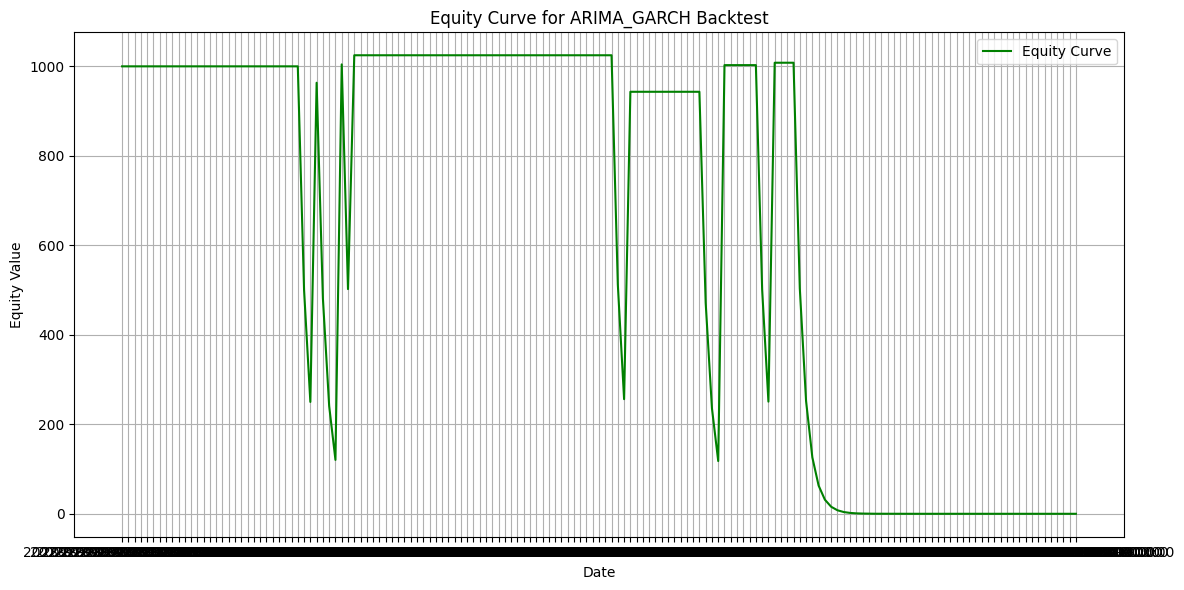

In [136]:
# equity_values
plt.figure(figsize=(12, 6))
plt.plot(backtest['Date'], ARIMA_GARCH_equity_values, label='Equity Curve', color='green')
plt.title('Equity Curve for ARIMA_GARCH Backtest')
plt.xlabel('Date')
plt.ylabel('Equity Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

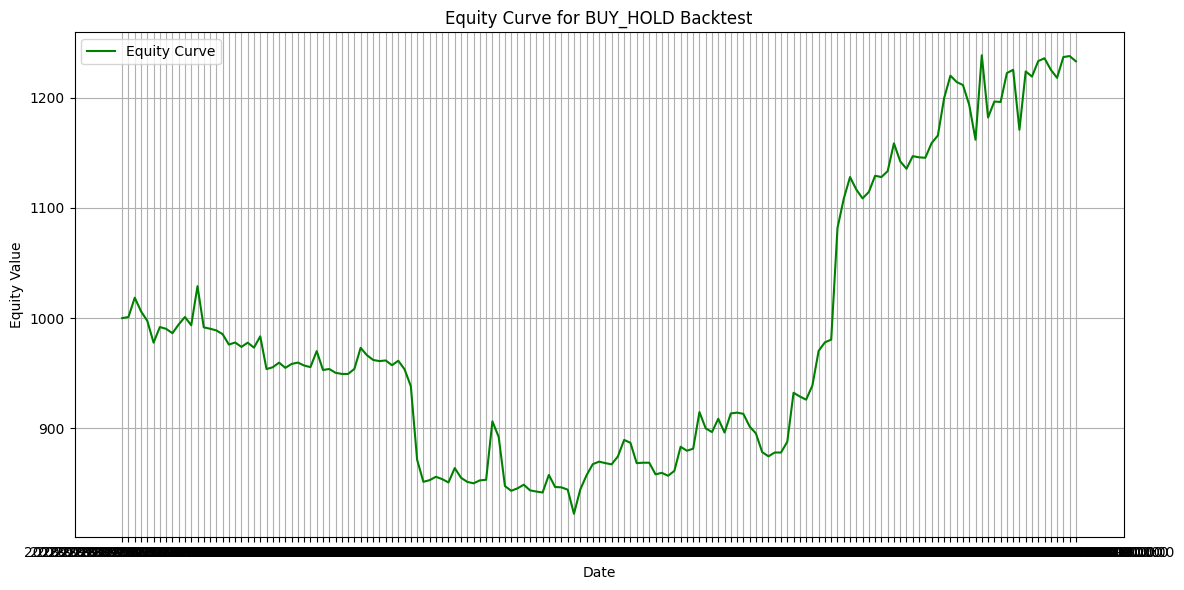

In [137]:
plt.figure(figsize=(12, 6))
plt.plot(backtest['Date'], BUY_HOLD_equity_values, label='Equity Curve', color='green')
plt.title('Equity Curve for BUY_HOLD Backtest')
plt.xlabel('Date')
plt.ylabel('Equity Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()